In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

# Additional performance metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [27]:
df = pd.read_csv('final_combined_dataset.csv')


In [28]:
df.dtypes

date                                     object
week                                      int64
cases                                     int64
population                                int64
tempe_min                               float64
humidity_max                            float64
humidity_avg                            float64
humidity_min                            float64
temp_avg                                float64
temp_max                                float64
city                                     object
geocode                                   int64
vim                                     float64
vim_monthly                             float64
precipitation_avg_ordinary_kriging      float64
precipitation_max_ordinary_kriging      float64
precipitation_avg_regression_kriging    float64
precipitation_max_regression_kriging    float64
long                                    float64
lat                                     float64
cases_per_100k                          

In [29]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1,-2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[3,4])
data = data.dropna().reset_index(drop=True)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Store 'geocode' in a separate column before transforming
data['geocode_original'] = data['geocode']

ct = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse_output=False), ['geocode'])
], remainder='passthrough')

transformed_data = ct.fit_transform(data)

# Get feature names
feature_names = ct.get_feature_names_out()

# Clean feature names to remove 'remainder__' prefix
cleaned_feature_names = [name.split('__')[-1] if 'remainder__' in name else name for name in feature_names]

# Convert transformed data back to DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=cleaned_feature_names)

numeric_cols = data.select_dtypes(include=['float64', 'int64','int32']).columns
for col in numeric_cols:
    if col in transformed_df.columns:
        transformed_df[col] = pd.to_numeric(transformed_df[col], errors='coerce')

if 'date' in transformed_df.columns:
    transformed_df['date'] = pd.to_datetime(transformed_df['date'], errors='coerce')

print(transformed_df.dtypes)
data= transformed_df

# Now 'transformed_df' contains the transformed data with the correct types
print(transformed_df.dtypes) 

train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]

X_train = train_data.drop(columns=['cases','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_lag-2'])
y_test = test_data[['cases_lag-2']]

data = data.drop(columns=['cases_per_100k'])

data

onehot__geocode_3300100                       object
onehot__geocode_3300159                       object
onehot__geocode_3300209                       object
onehot__geocode_3300225                       object
onehot__geocode_3300233                       object
                                              ...   
precipitation_avg_regression_kriging_lag3    float64
precipitation_avg_regression_kriging_lag4    float64
precipitation_max_regression_kriging_lag3    float64
precipitation_max_regression_kriging_lag4    float64
geocode_original                               int64
Length: 145, dtype: object
onehot__geocode_3300100                       object
onehot__geocode_3300159                       object
onehot__geocode_3300209                       object
onehot__geocode_3300225                       object
onehot__geocode_3300233                       object
                                              ...   
precipitation_avg_regression_kriging_lag3    float64
precipitation_avg_r

onehot__geocode_3300100 onehot__geocode_3300159 onehot__geocode_3300209  \
0                         1.0                     0.0                     0.0   
1                         1.0                     0.0                     0.0   
2                         1.0                     0.0                     0.0   
3                         1.0                     0.0                     0.0   
4                         1.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300225 onehot__geocode_3300233 onehot__geocode_3300258  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300308 onehot__geocode_3300407 onehot__geocode_3300456  \
0                         0.0                     0.0                     0.0   
1                         0.0                     0.0                     0.0   
2                         0.0                     0.0                     0.0   
3                         0.0                     0.0                     0.0   
4                         0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
51683                     0.0                     0.0                     0.0   
51684                     0.0                     0.0                     0.0   
51685                     0.0                     0.0                     0.0   
51686                     0.0                     0.0                     0.0   
51687                     0.0                     0.0                     0.0   

      onehot__geocode_3300506  ... humidity_min_lag4  \
0                         0.0  ...         35.000000   
1                         0.0  ...         47.428571   
2                         0.0  ...         45.571429   
3                         0.0  ...         43.428571   
4                         0.0  ...         33.142857   
...                       ...  ...               ...   
51683                     0.0  ...         63.452716   
51684                     0.0  ...         61.497879   
51685                     0.0  ...         66.874779   
51686                     0.0  ...         67.027147   
51687                     0.0  ...         61.268456   

      precipitation_avg_ordinary_kriging_lag3  \
0                                      4.0716   
1                                      2.0555   
2                                      1.5416   
3                                      2.8204   
4                                      3.8170   
...                                       ...   
51683                                  2.3012   
51684                 

In [30]:
data.dtypes

onehot__geocode_3300100                       object
onehot__geocode_3300159                       object
onehot__geocode_3300209                       object
onehot__geocode_3300225                       object
onehot__geocode_3300233                       object
                                              ...   
precipitation_avg_regression_kriging_lag3    float64
precipitation_avg_regression_kriging_lag4    float64
precipitation_max_regression_kriging_lag3    float64
precipitation_max_regression_kriging_lag4    float64
geocode_original                               int64
Length: 144, dtype: object

Kernel: linear, C: 0.1, Epsilon: 0.0001, RMSE: 6.7112

Best Model Parameters: {'C': 0.1, 'epsilon': 0.0001, 'kernel': 'linear'}
Best RMSE: 6.71119321243385
R-squared (R²) for the train set: 0.8687
R-squared (R²) for the test set: 0.8322
Mean Absolute Error (MAE): 2.1584251836961226
Mean Absolute Percentage Error (MAPE): 3.186047323390213e+17 %
Train RMSE: 83.65209666239372
Test RMSE: 6.408146854470769


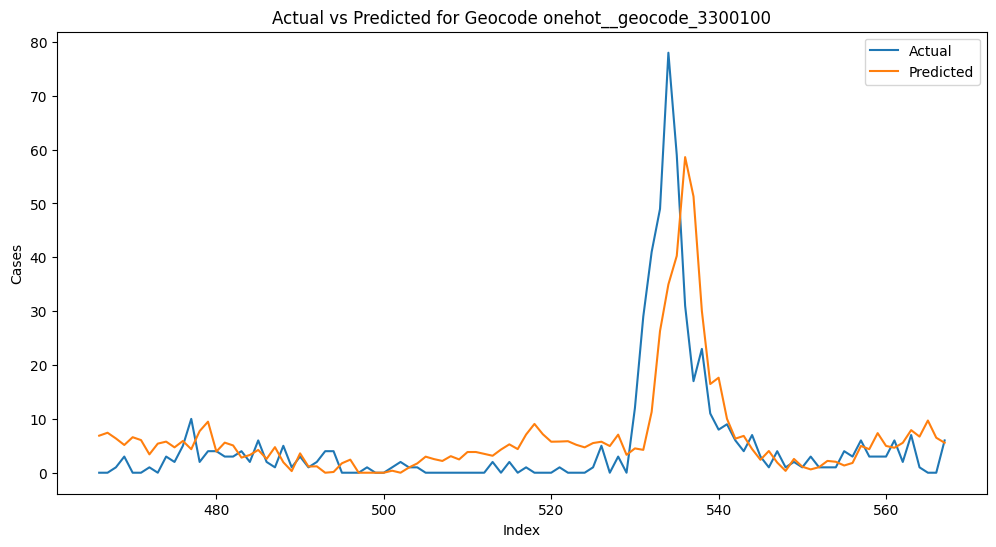

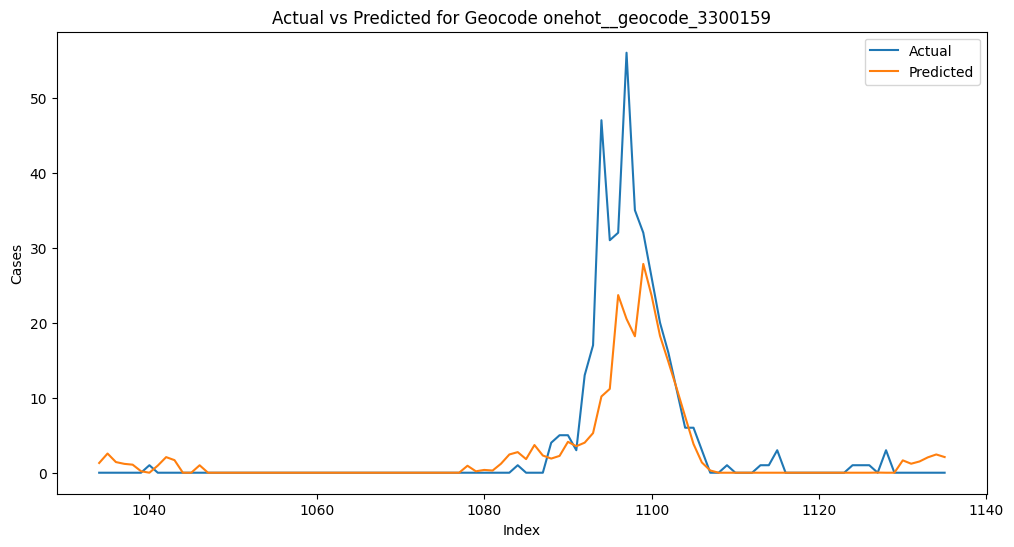

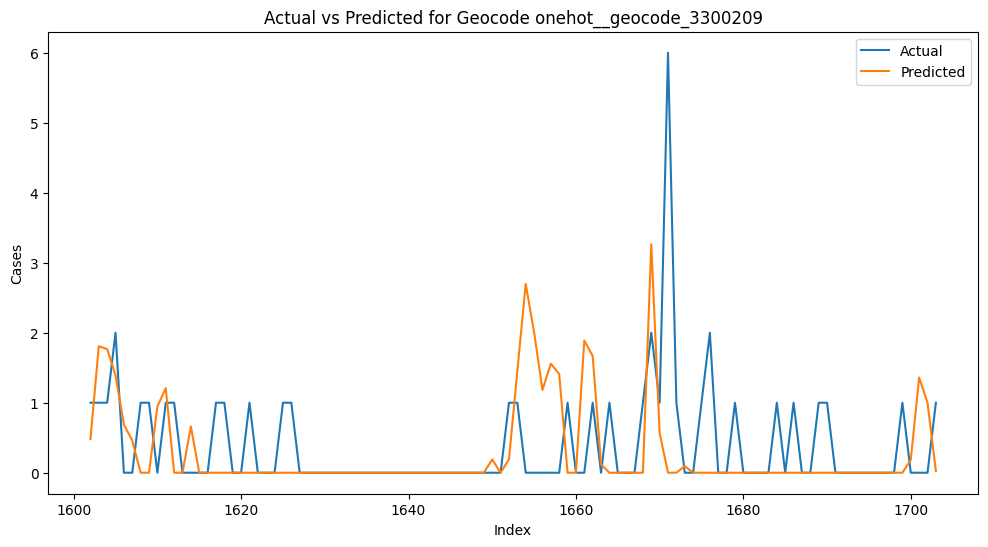

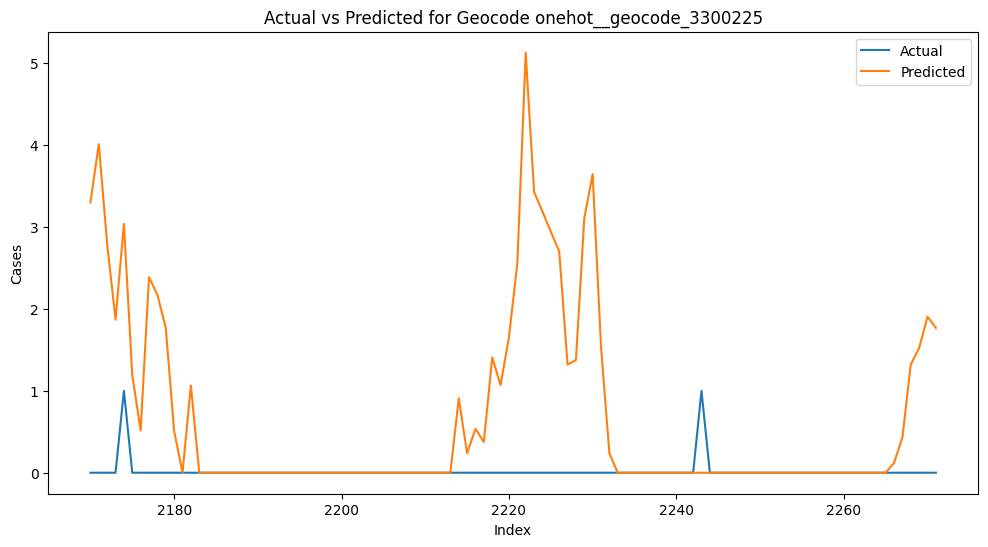

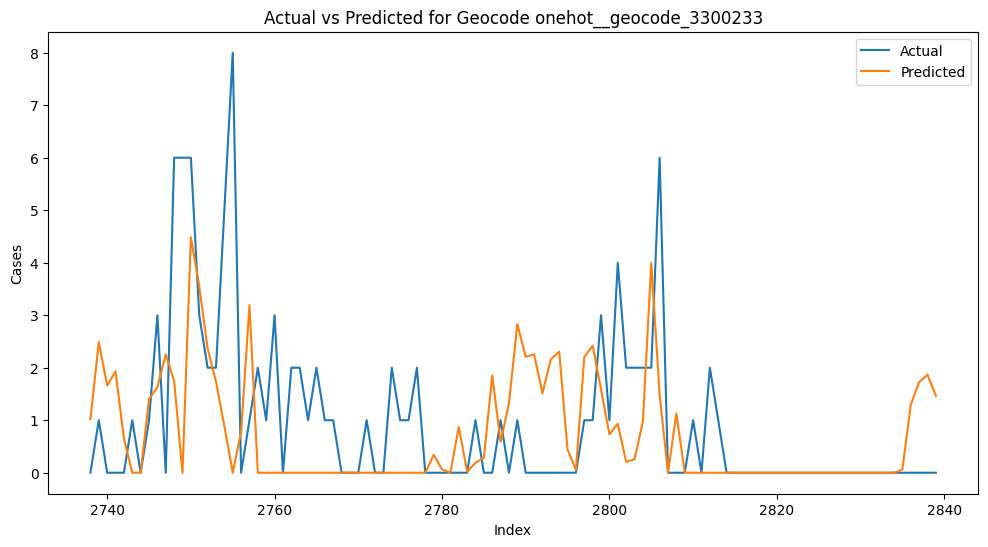

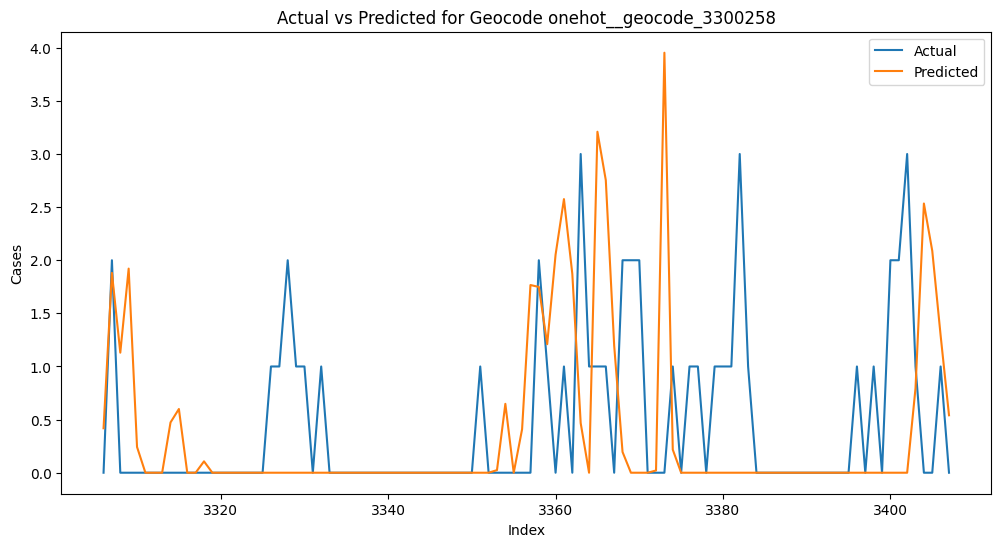

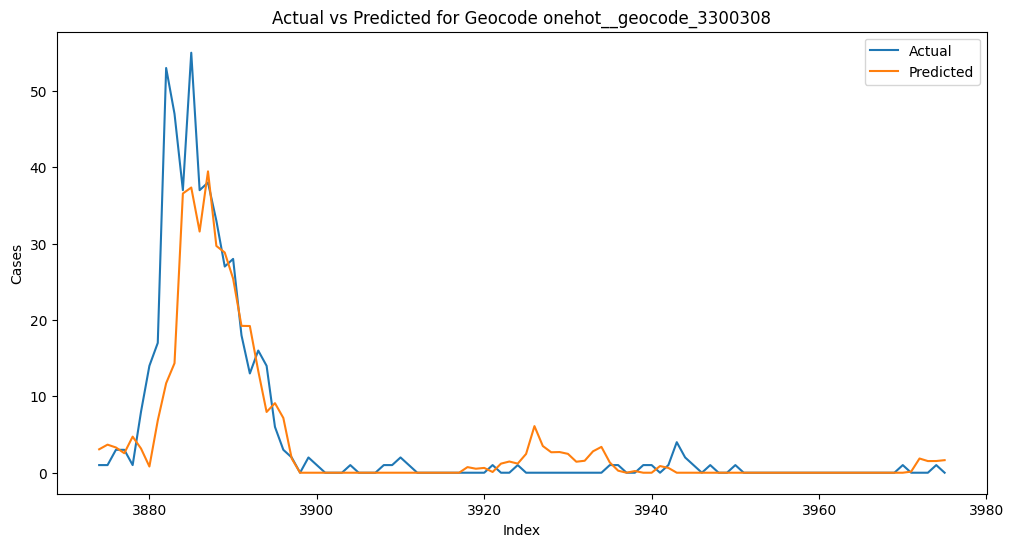

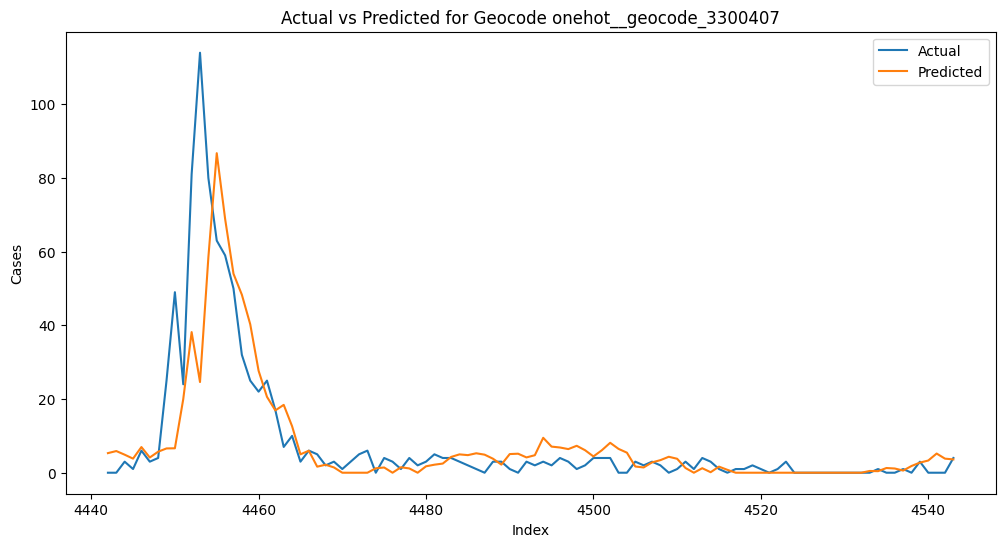

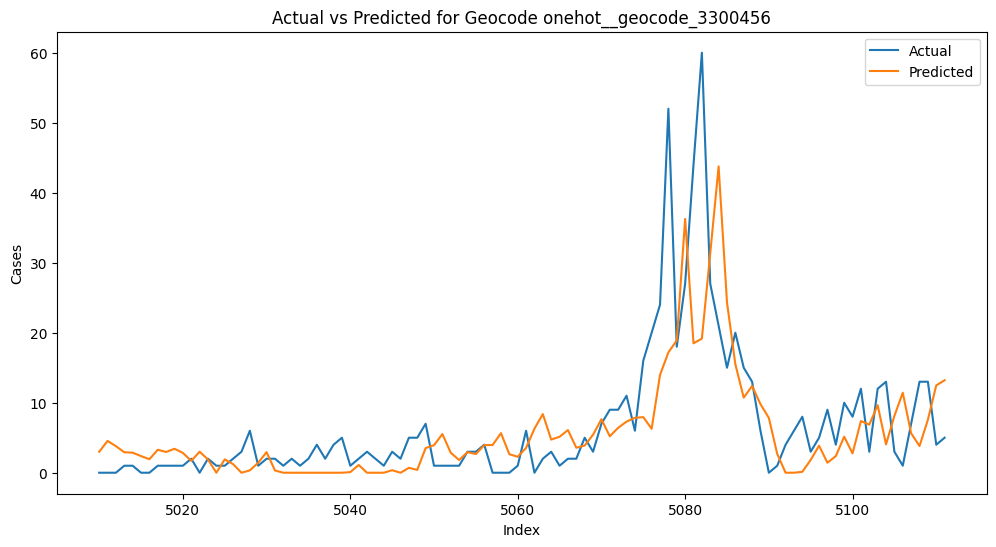

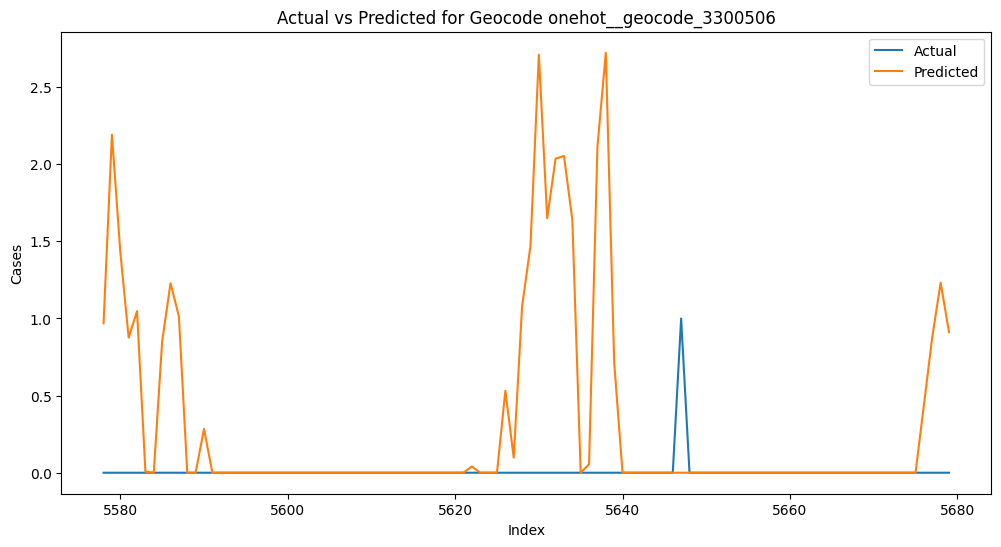

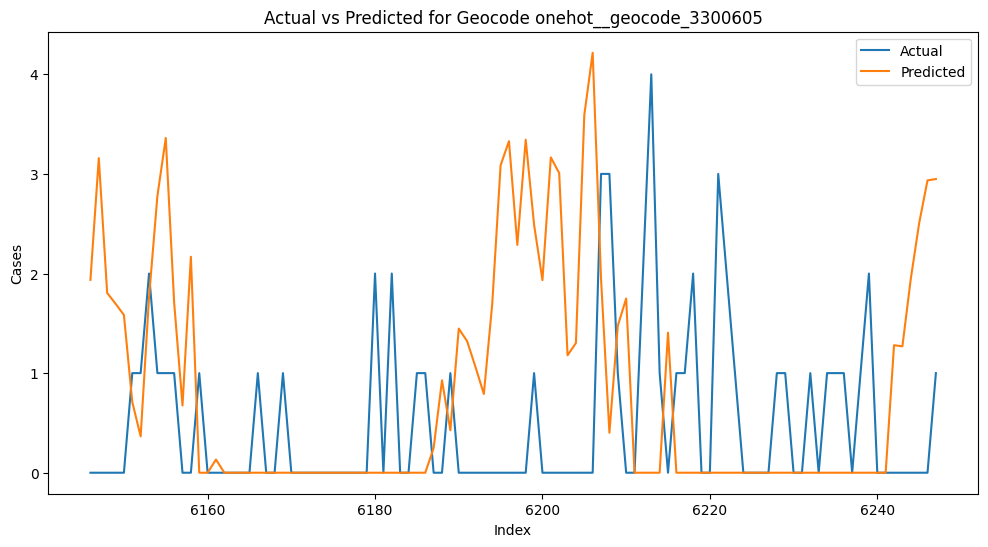

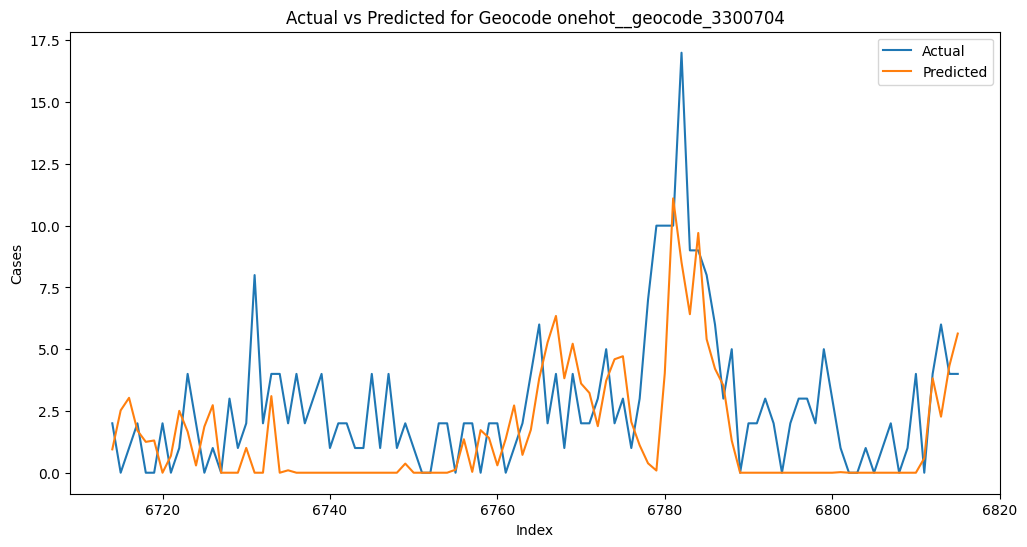

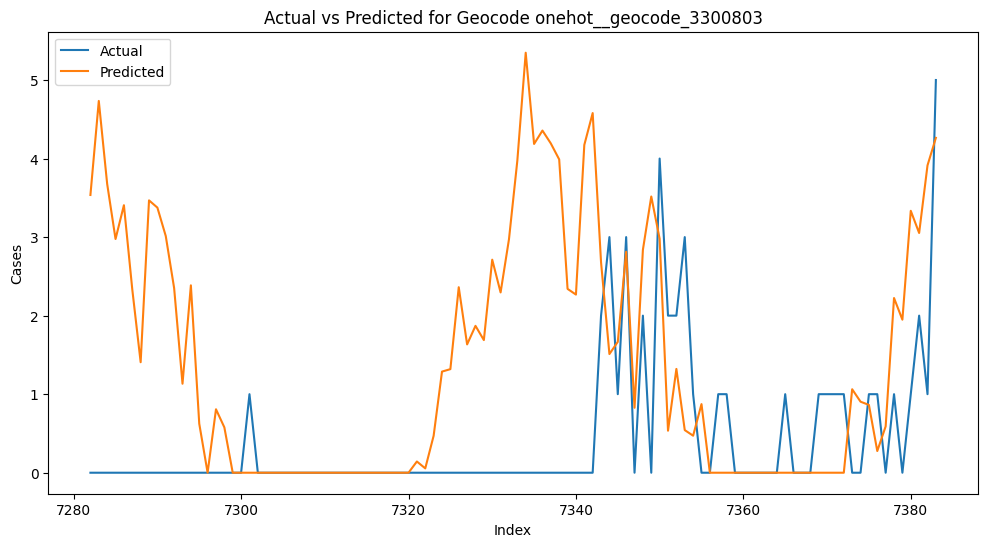

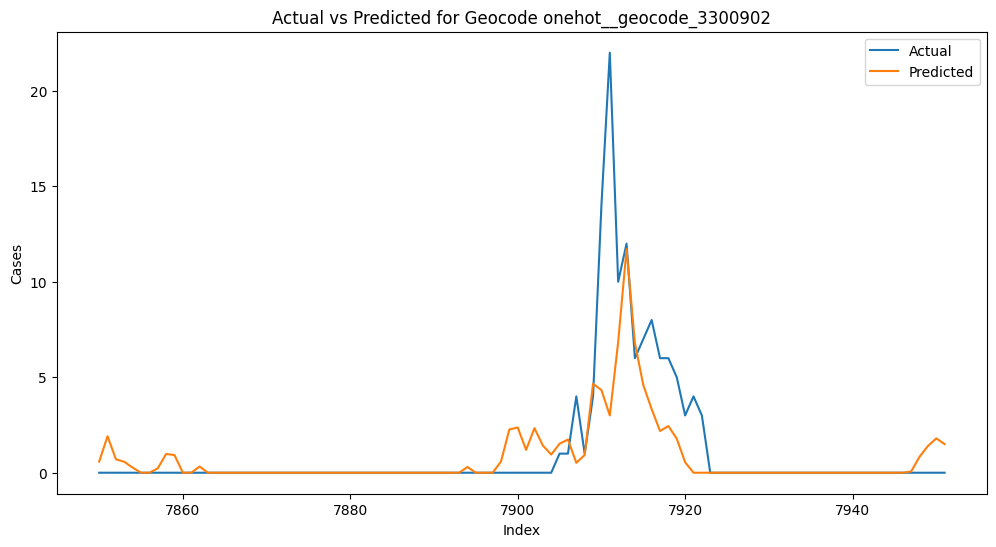

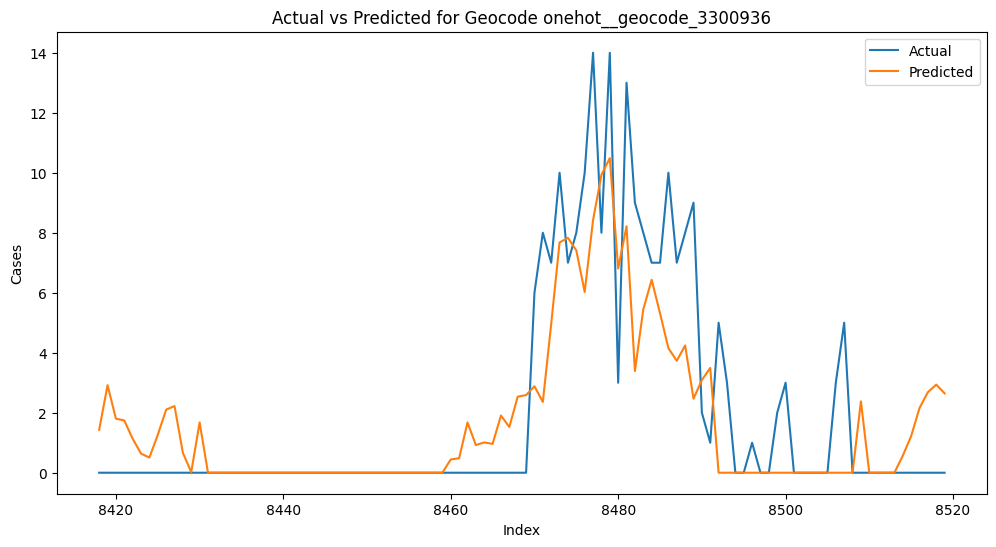

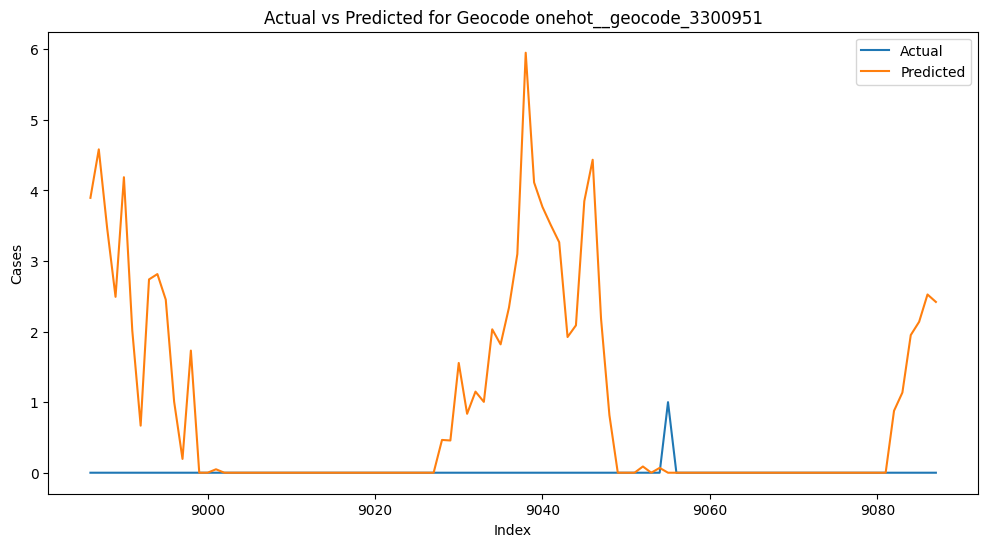

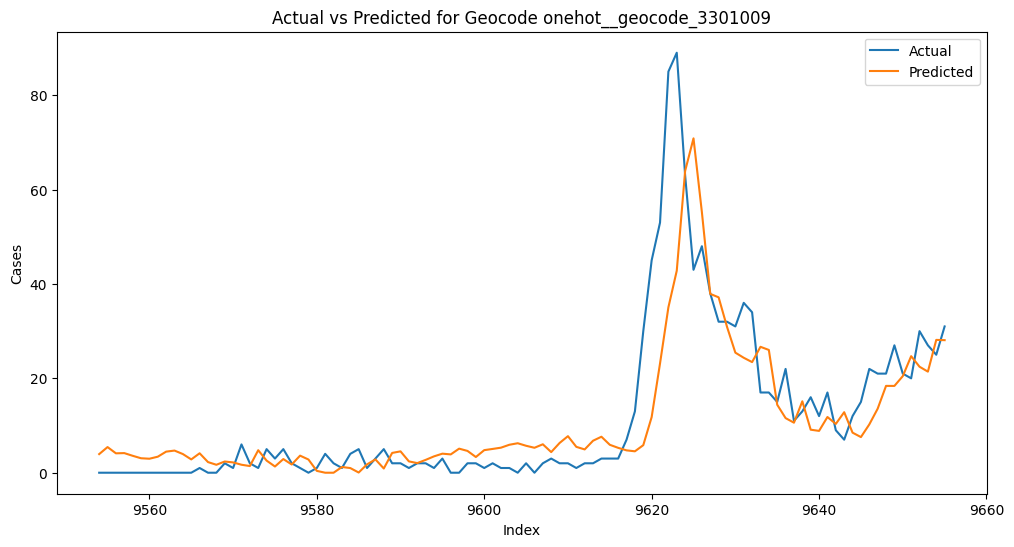

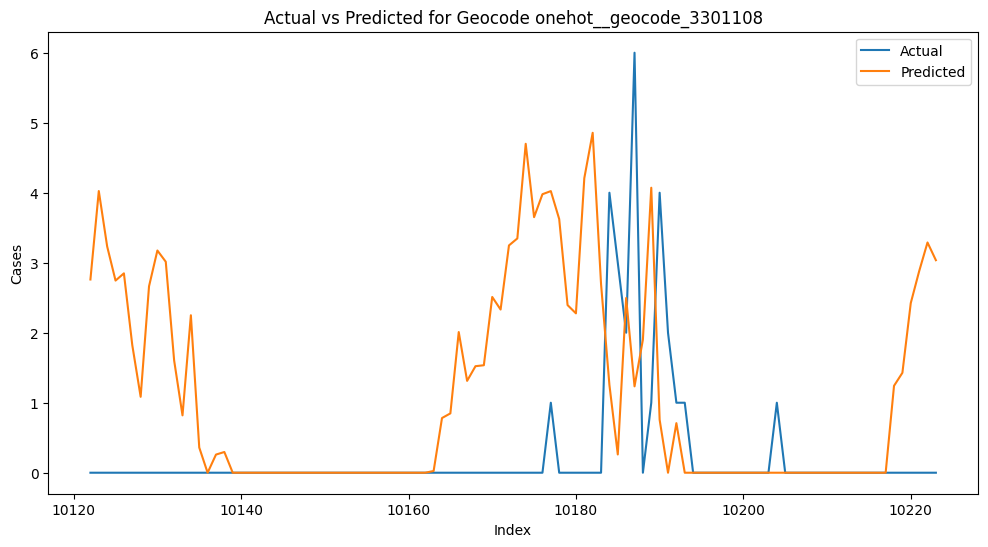

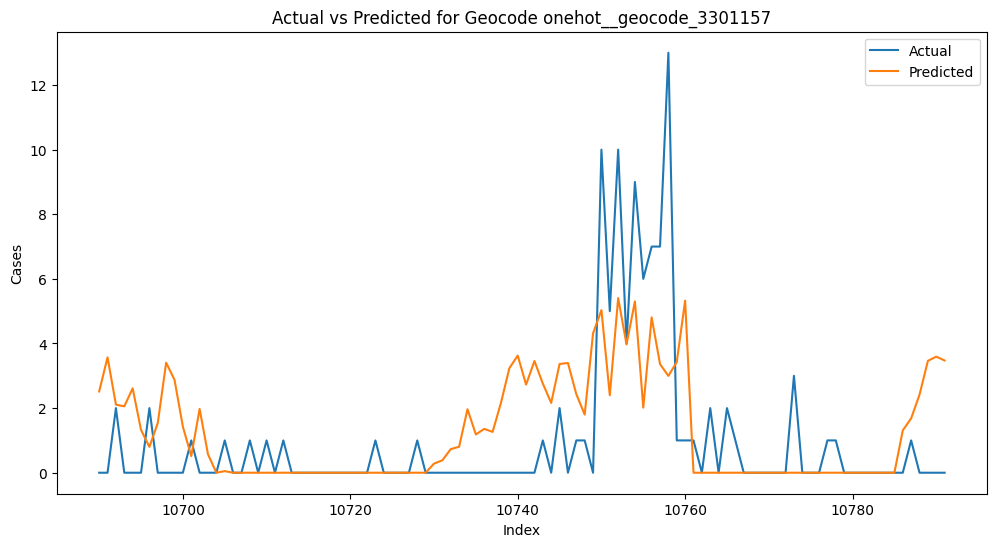

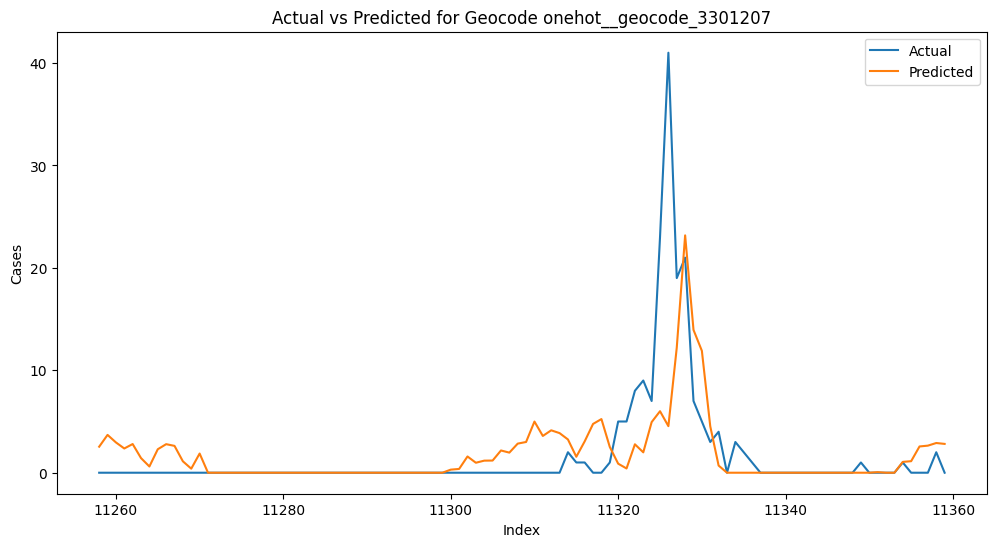

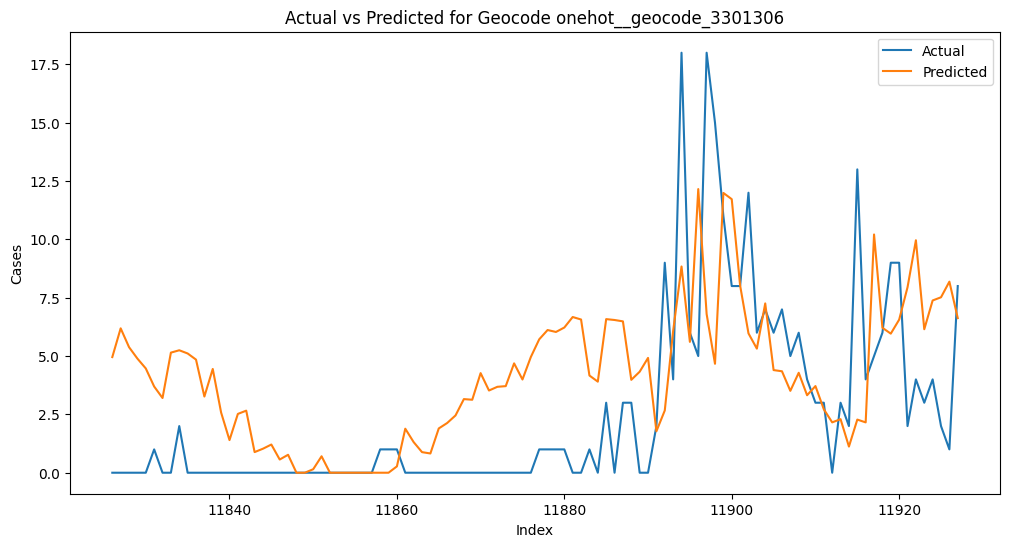

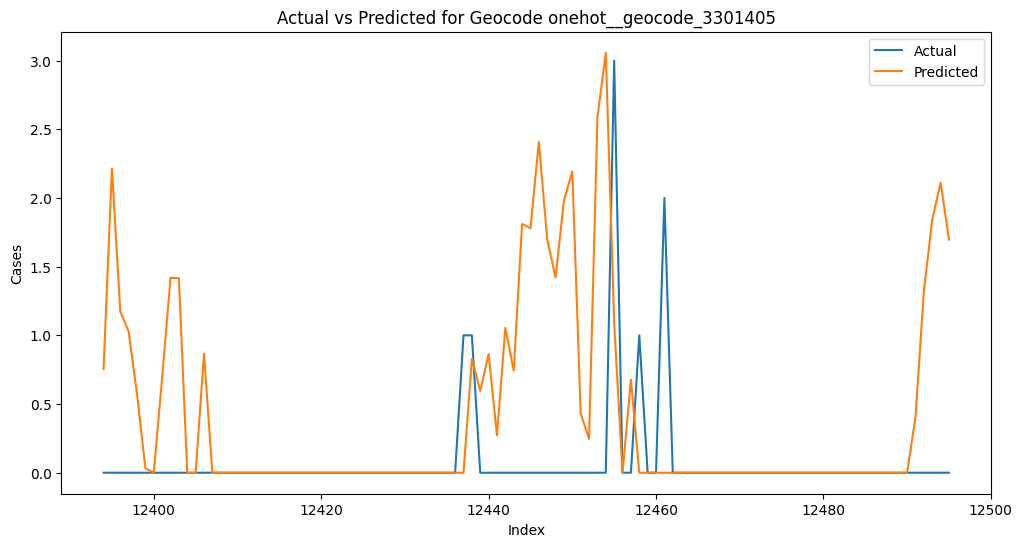

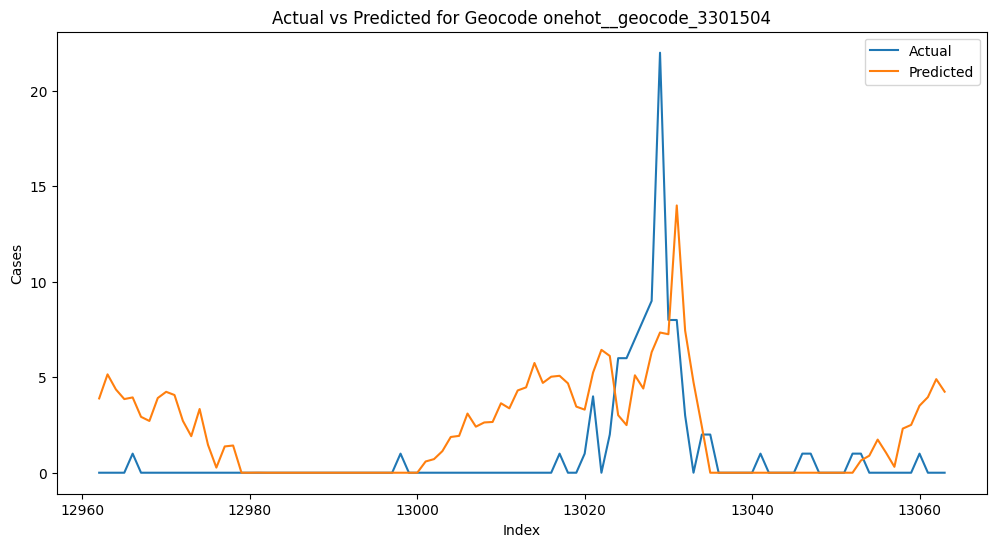

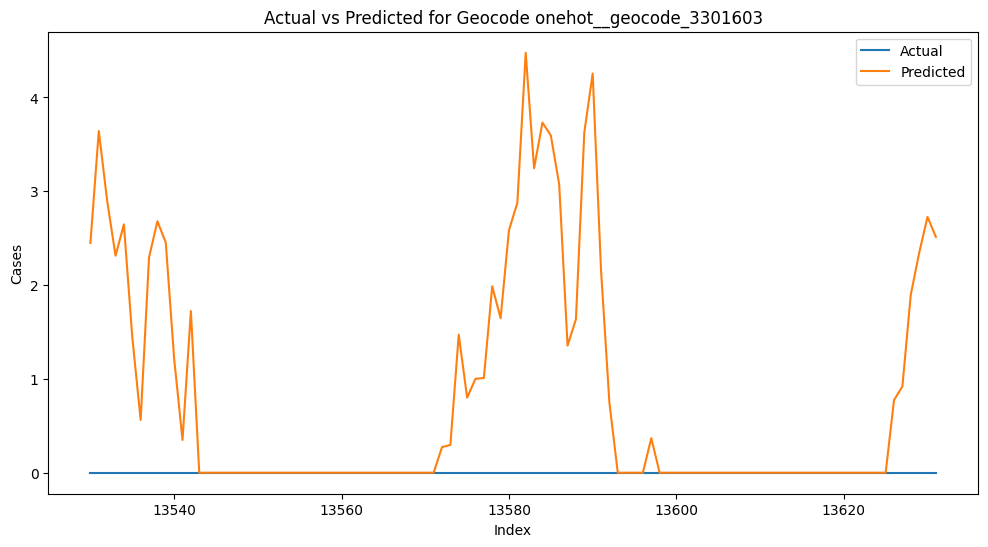

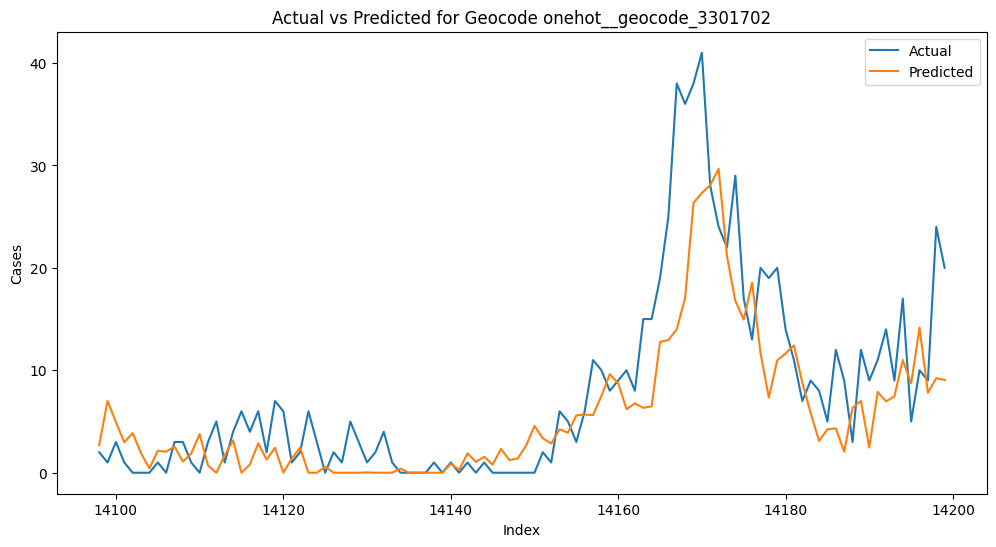

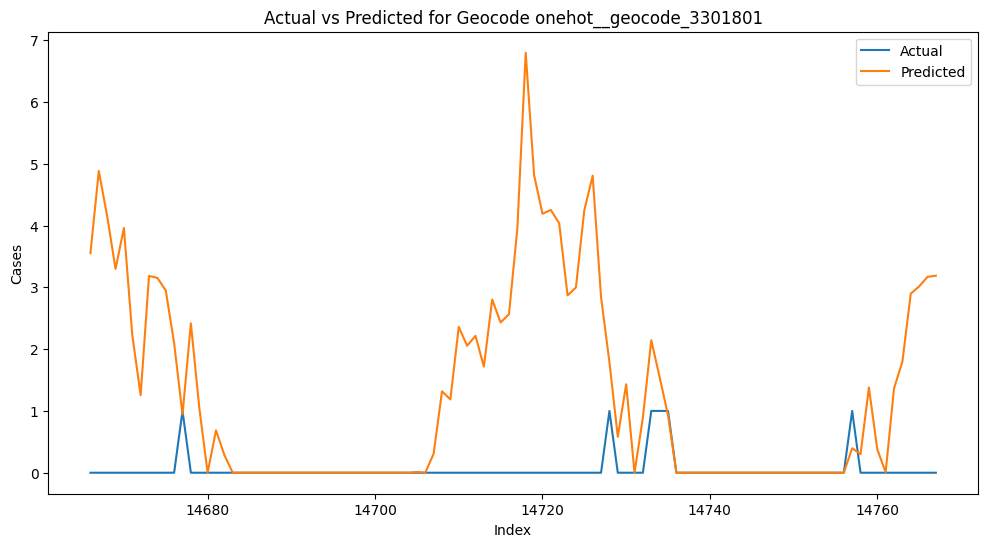

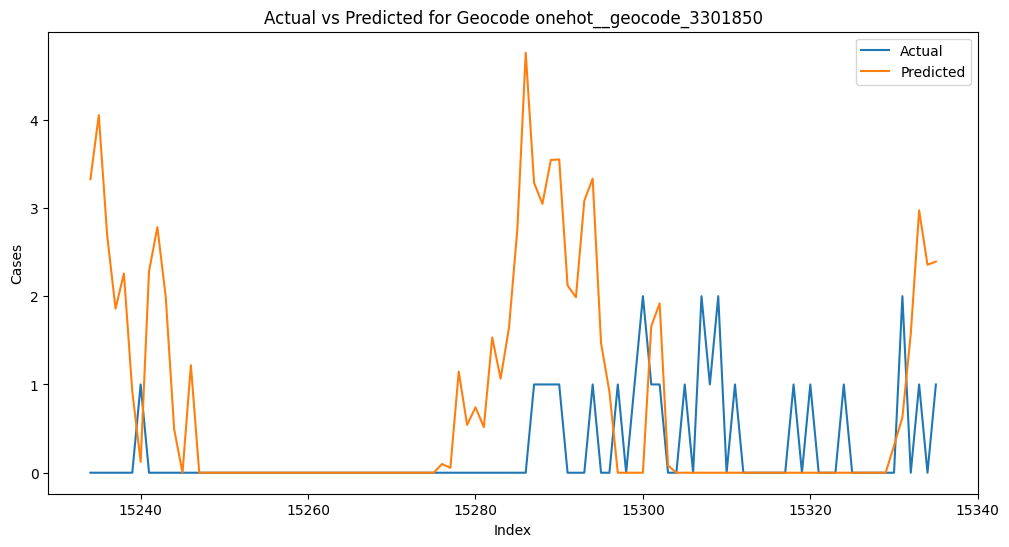

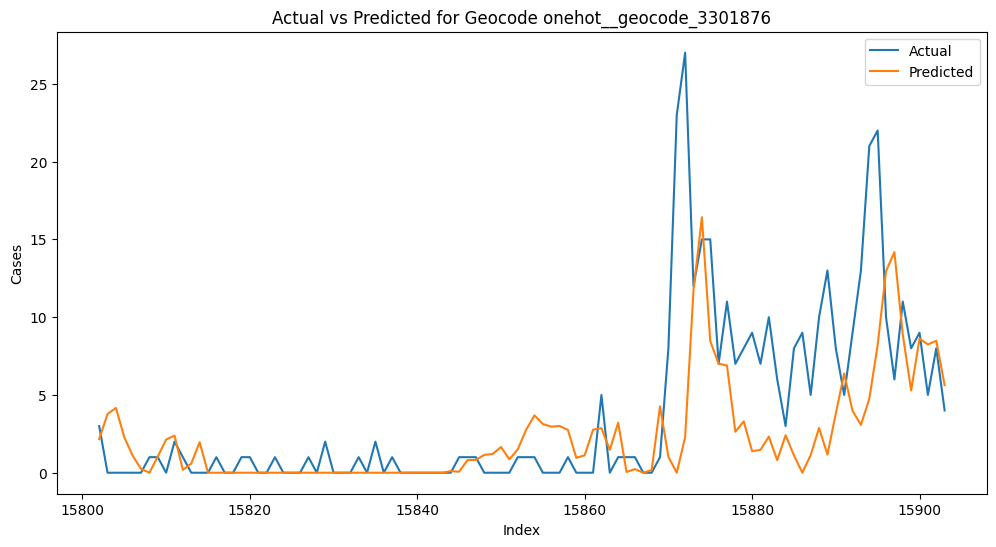

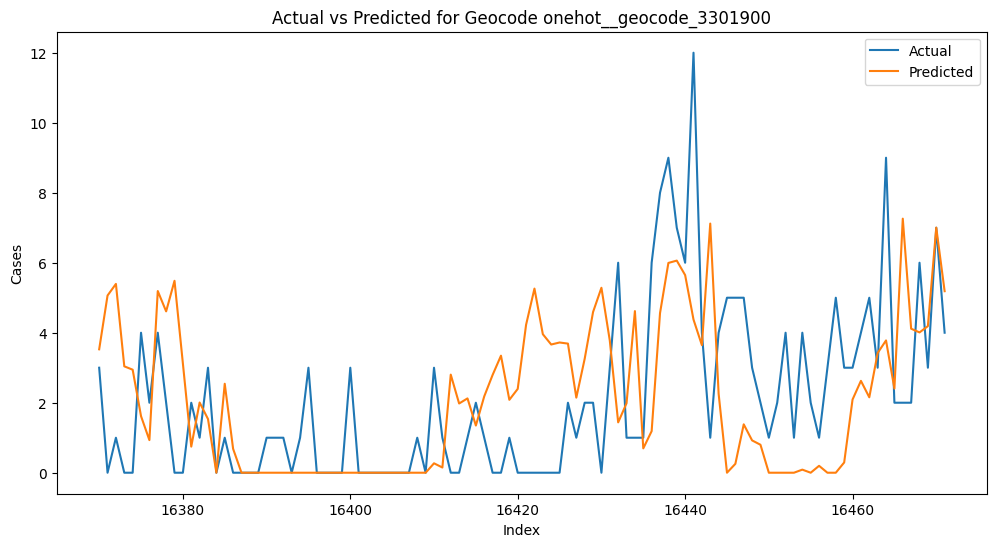

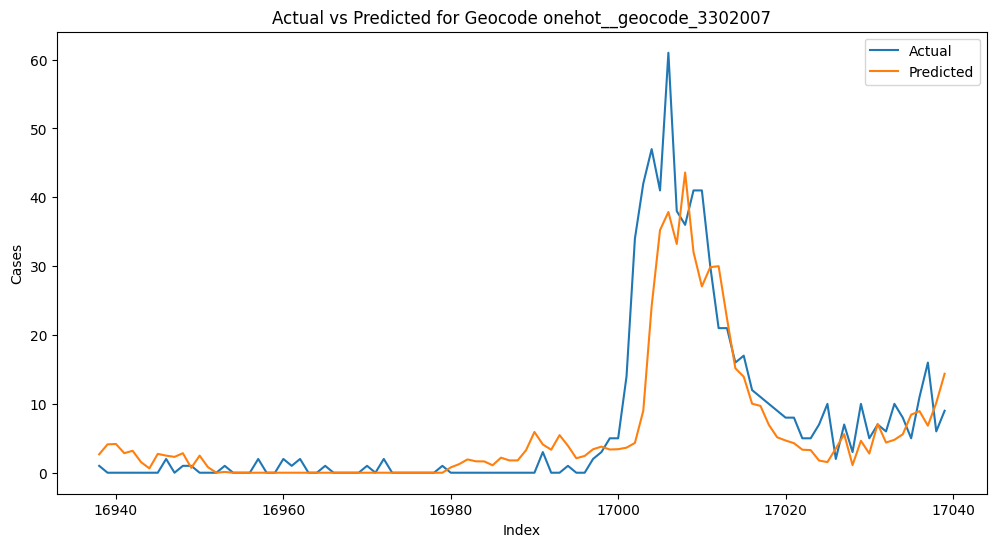

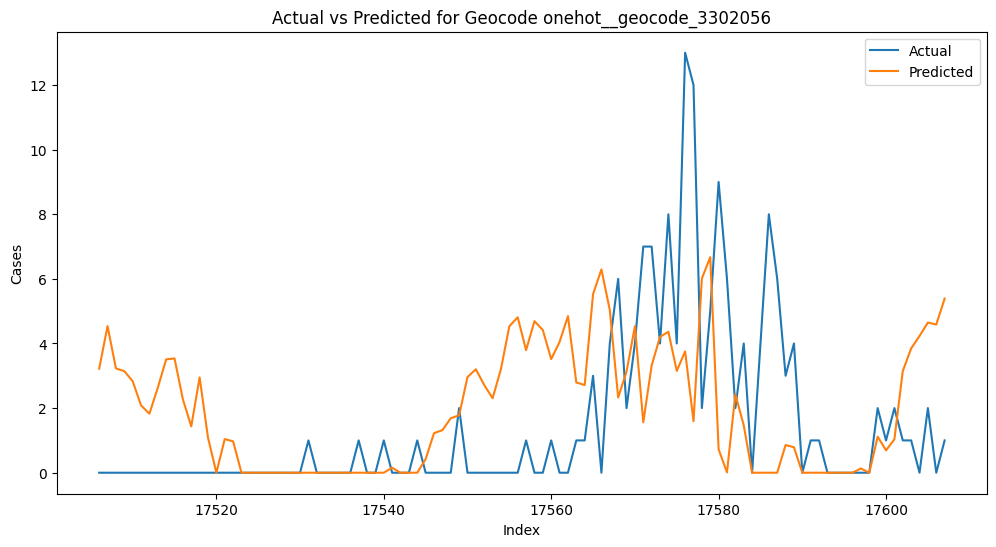

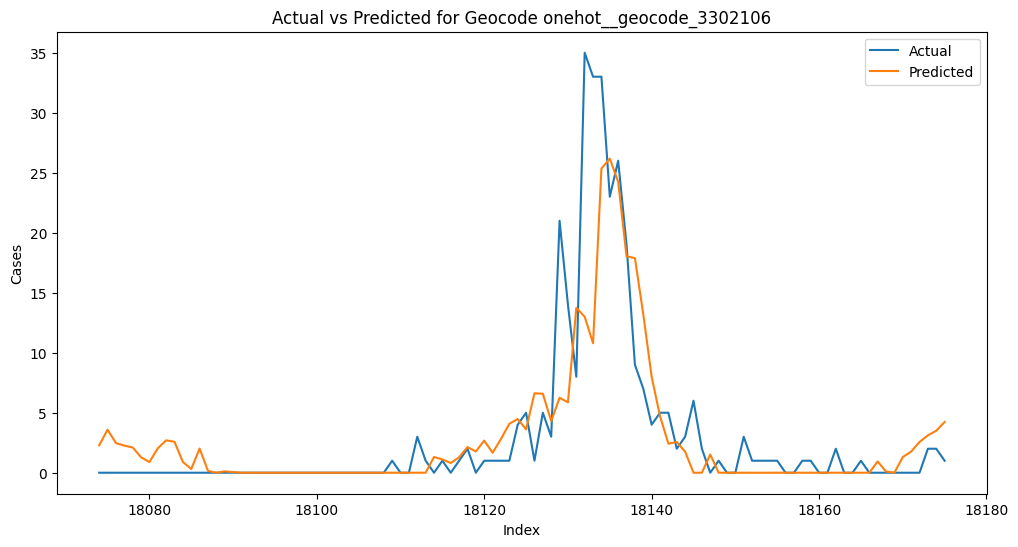

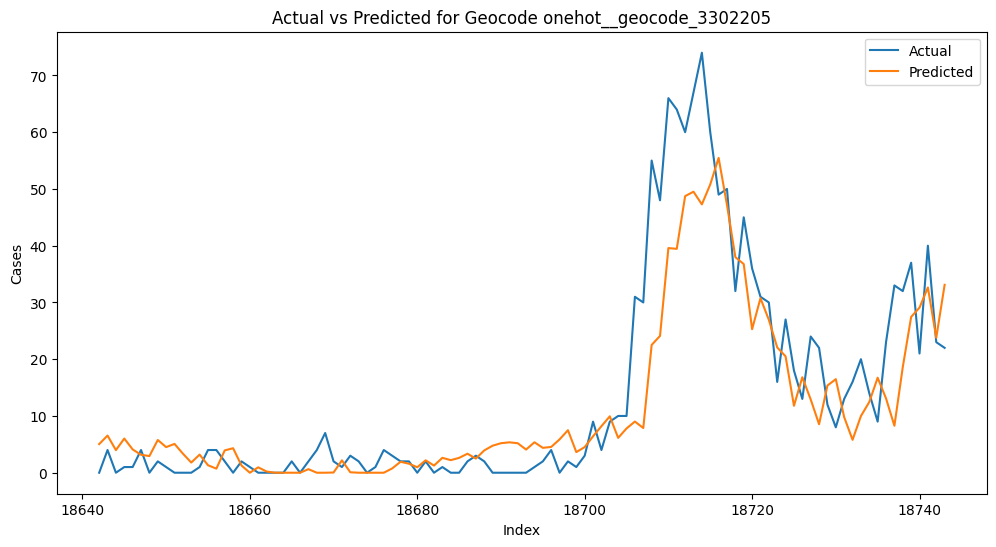

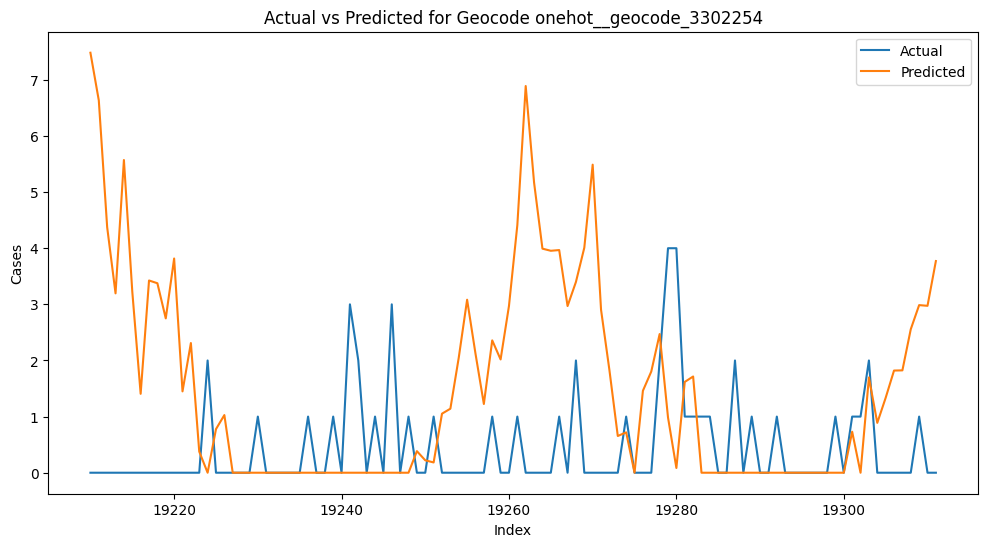

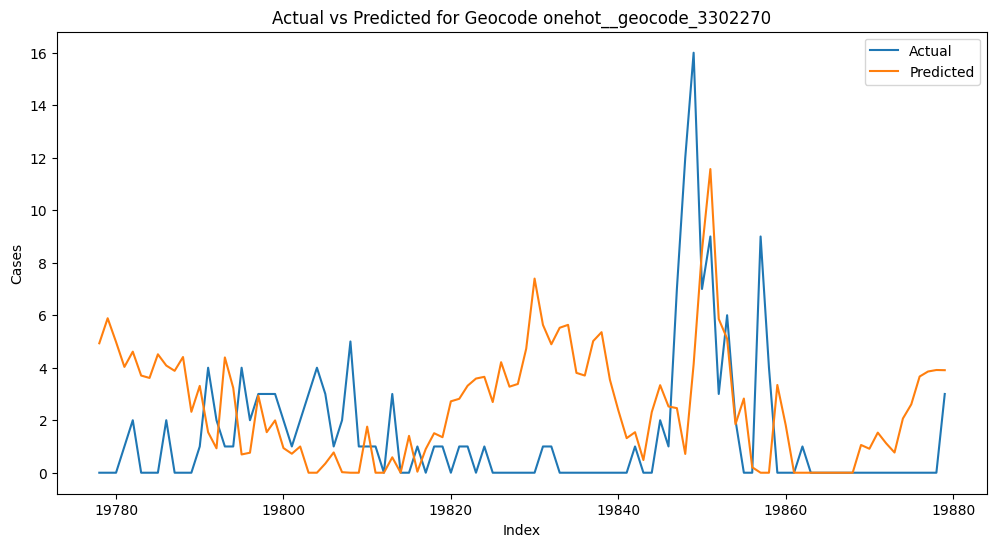

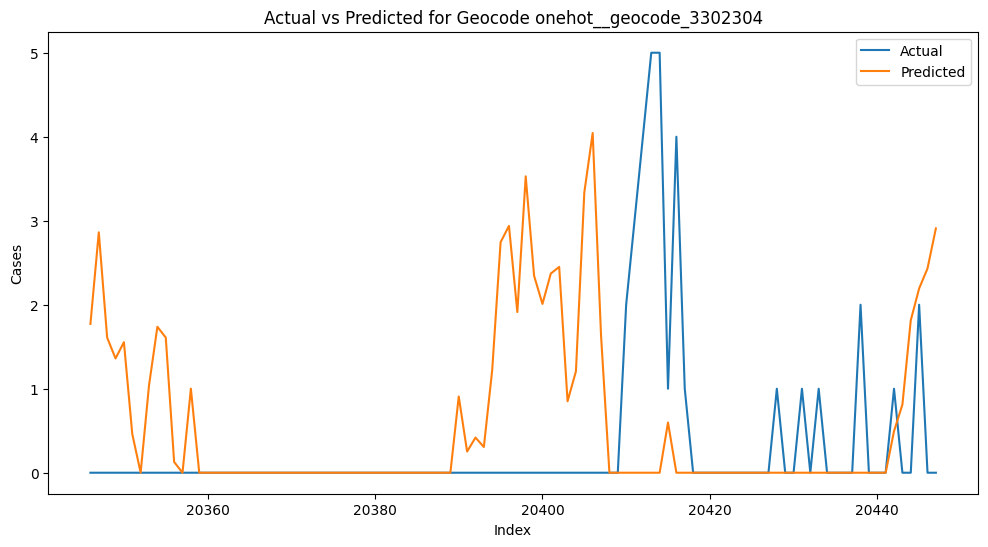

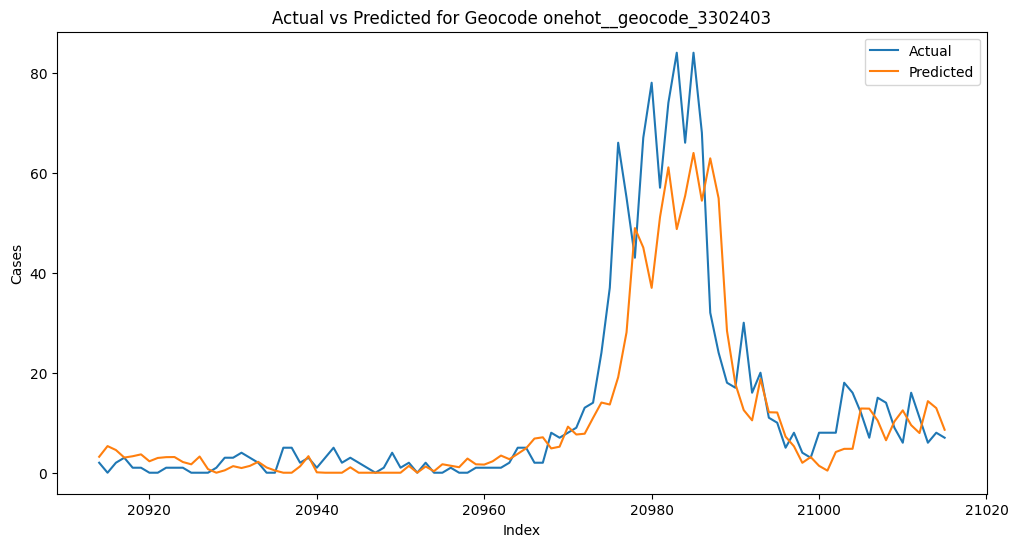

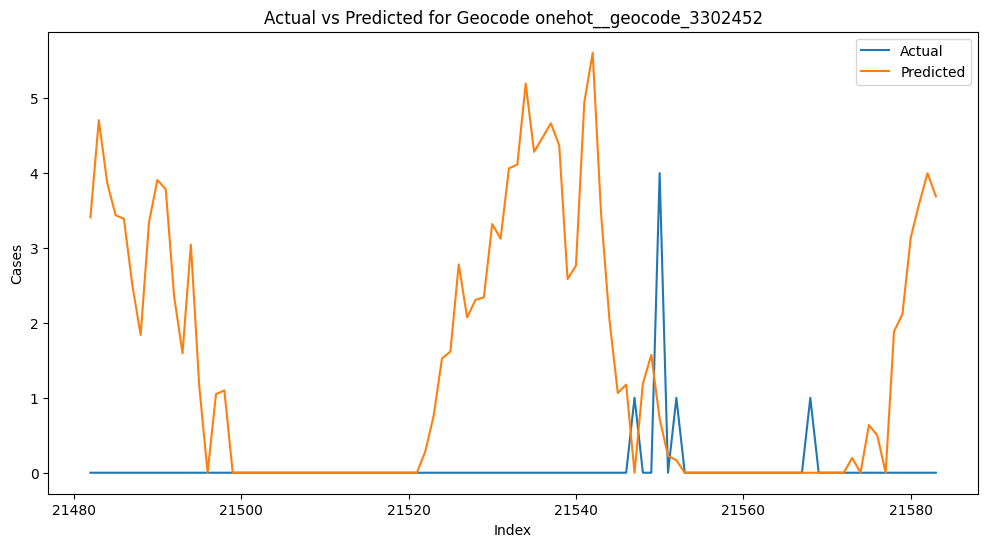

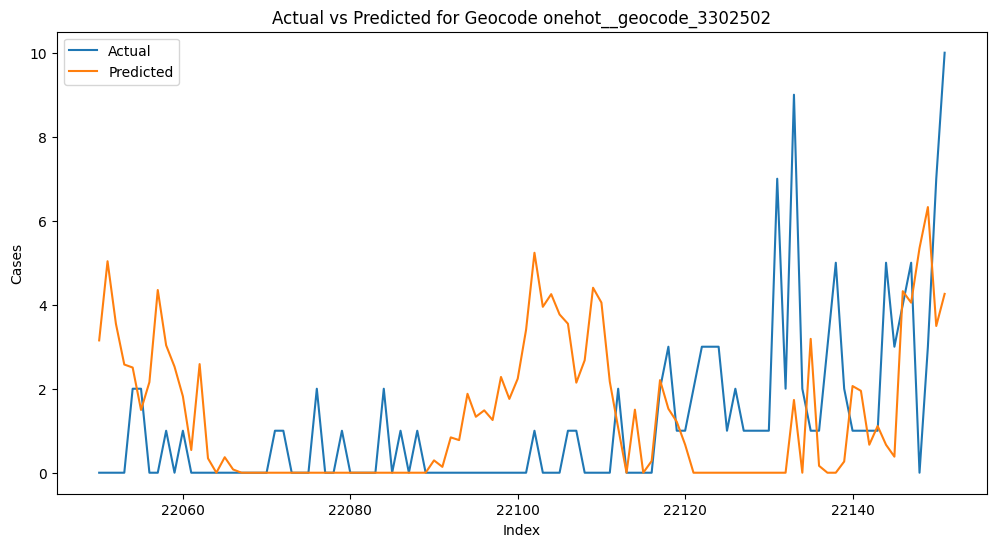

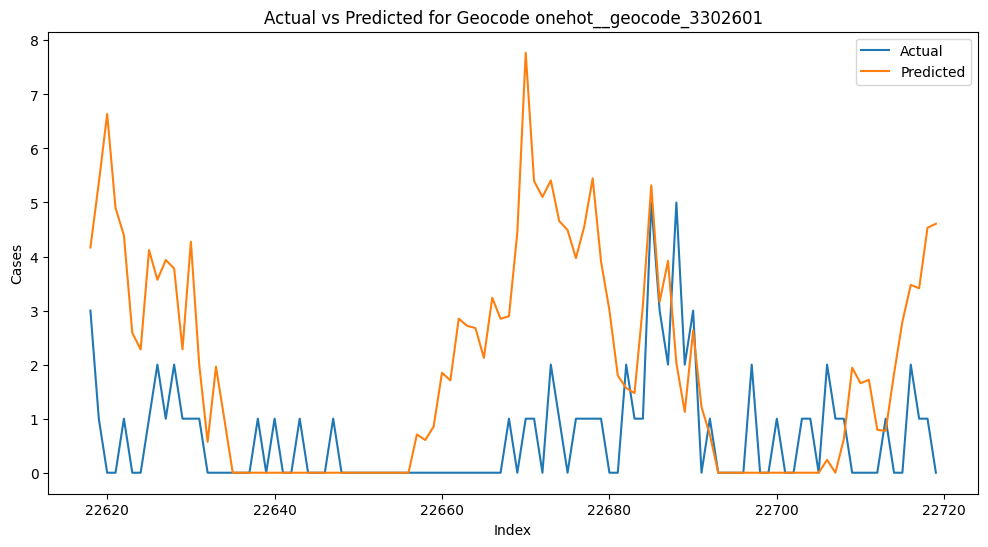

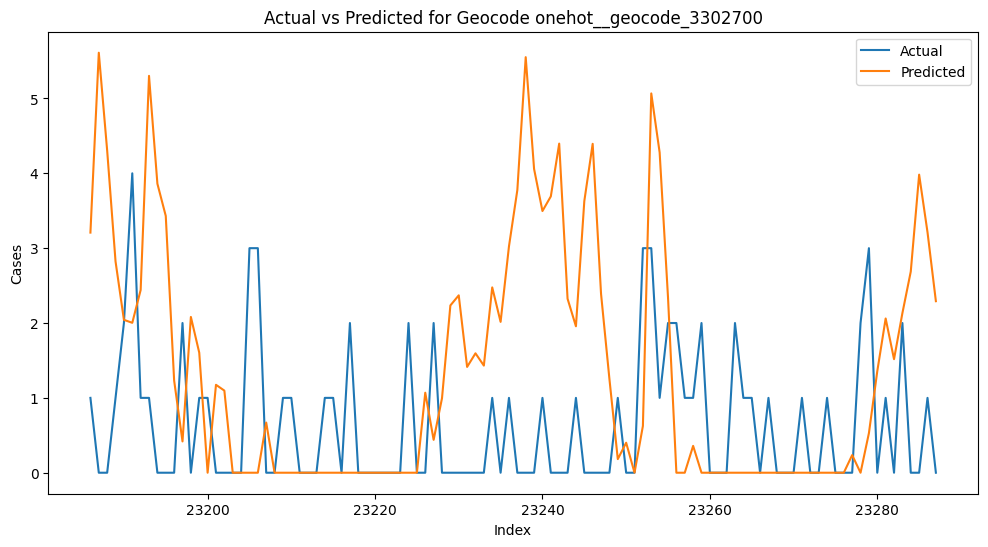

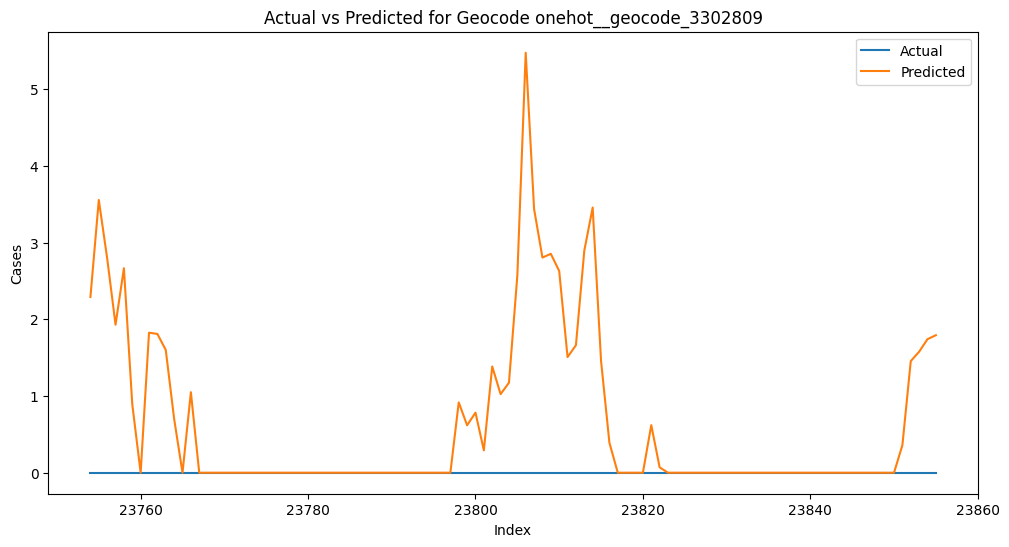

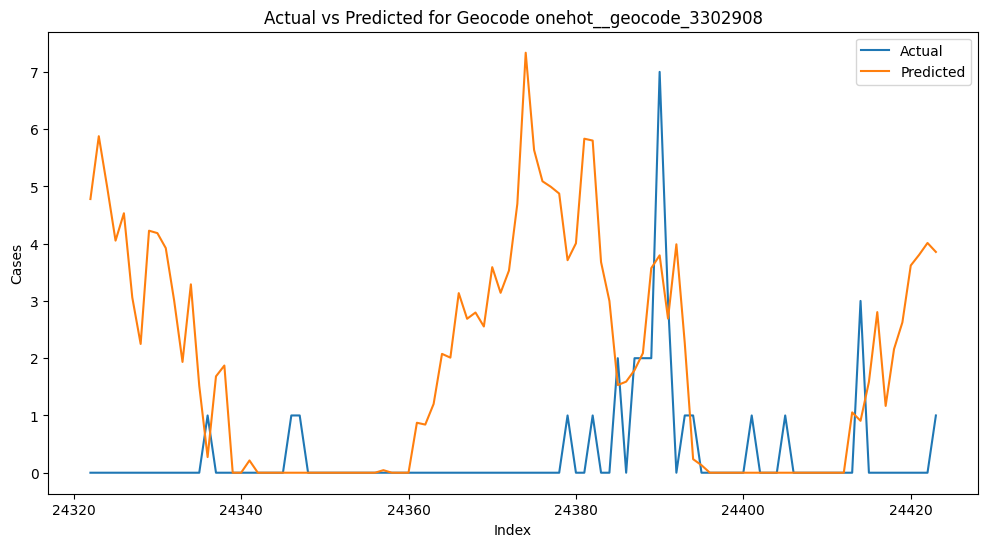

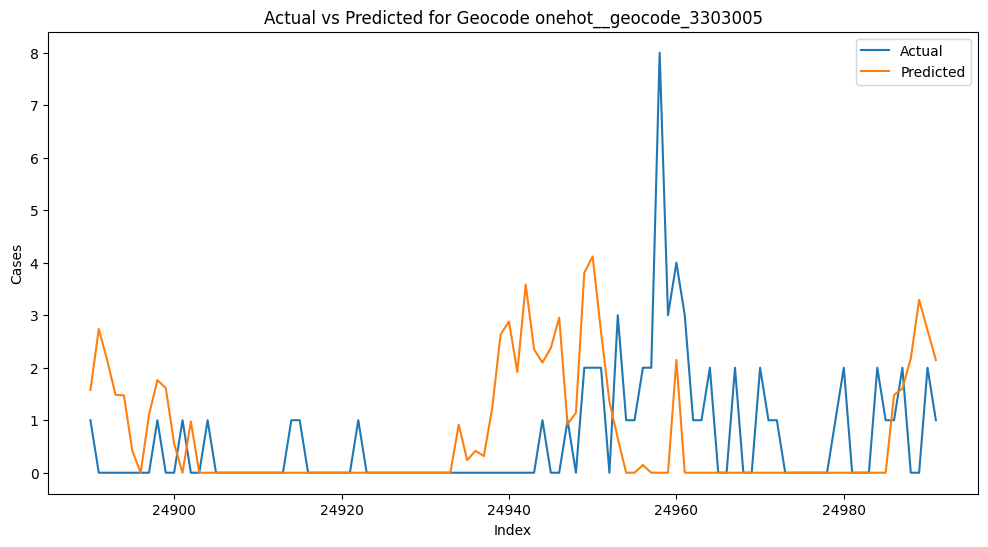

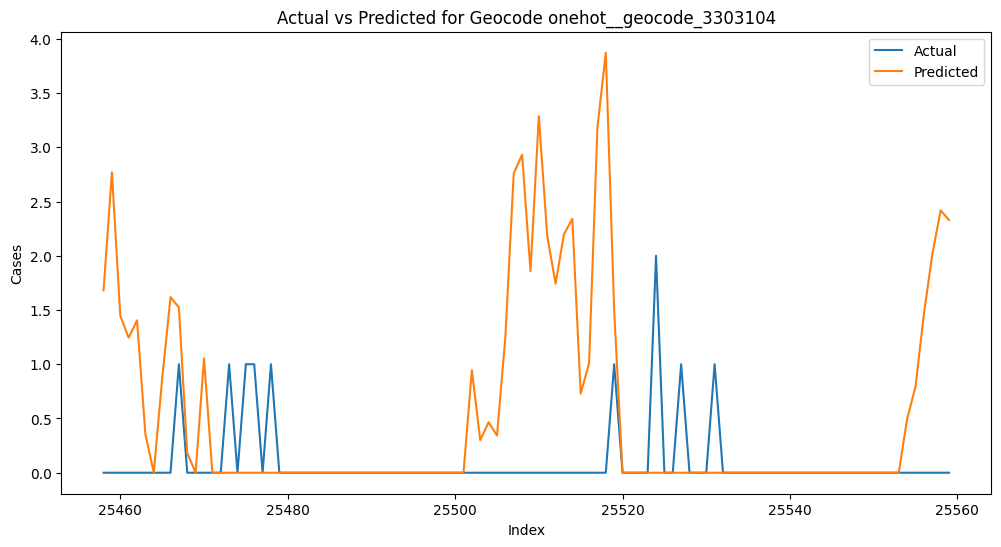

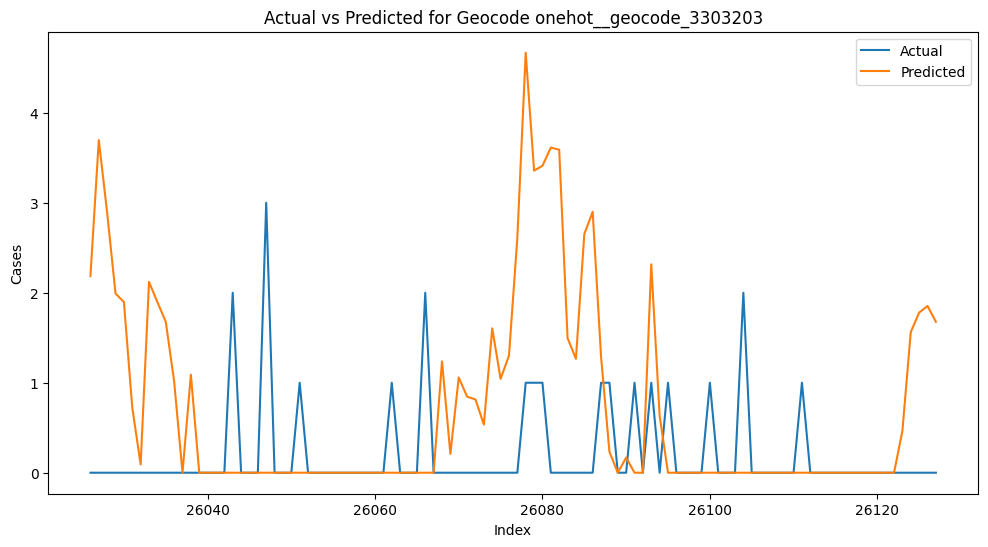

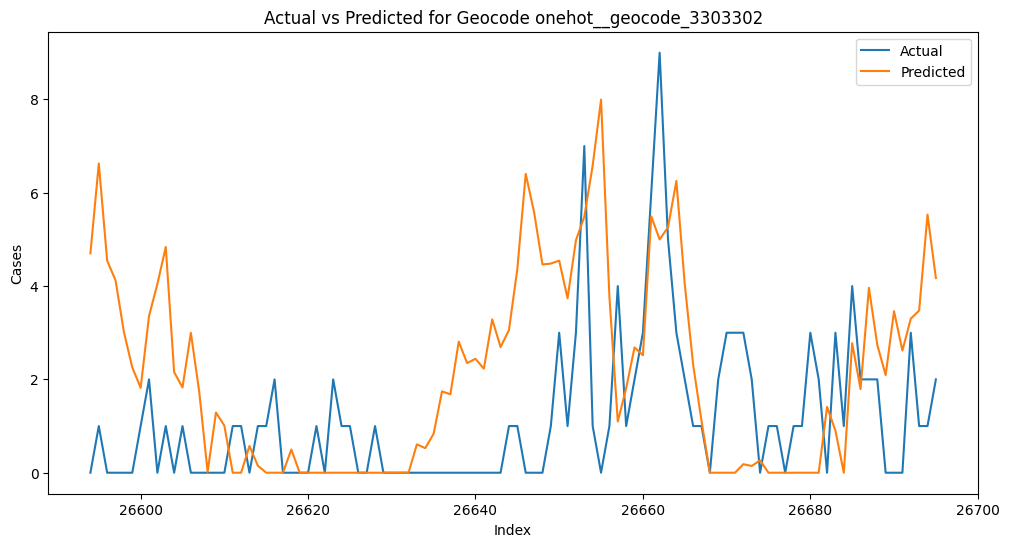

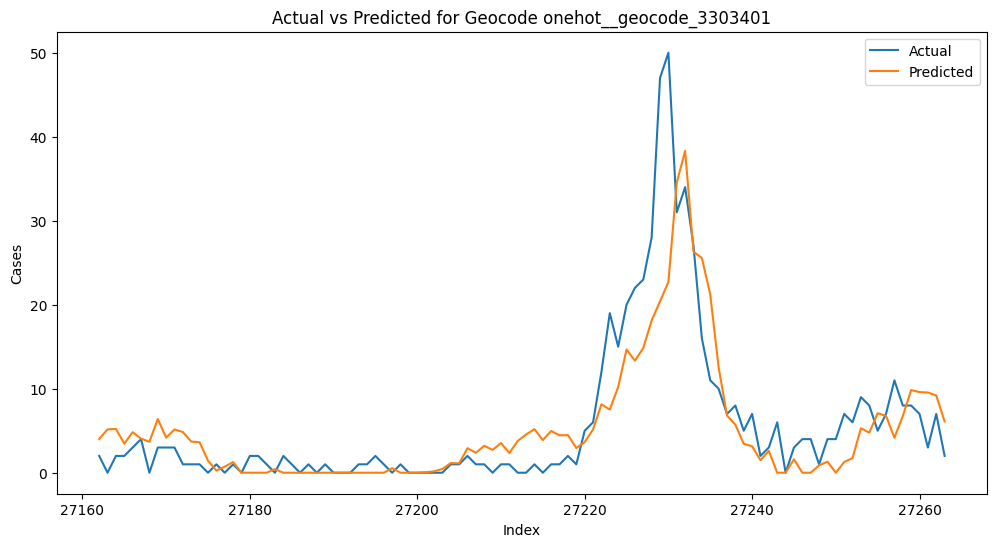

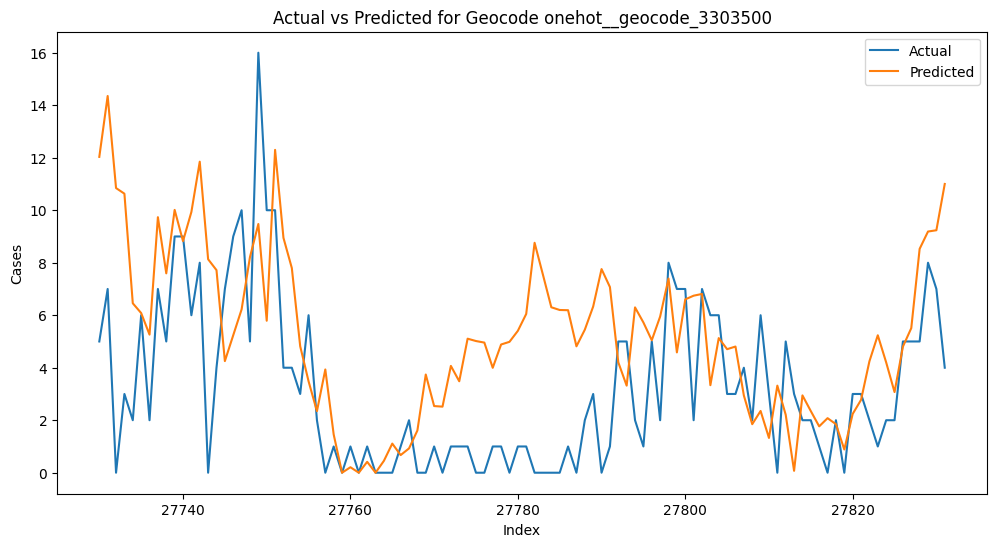

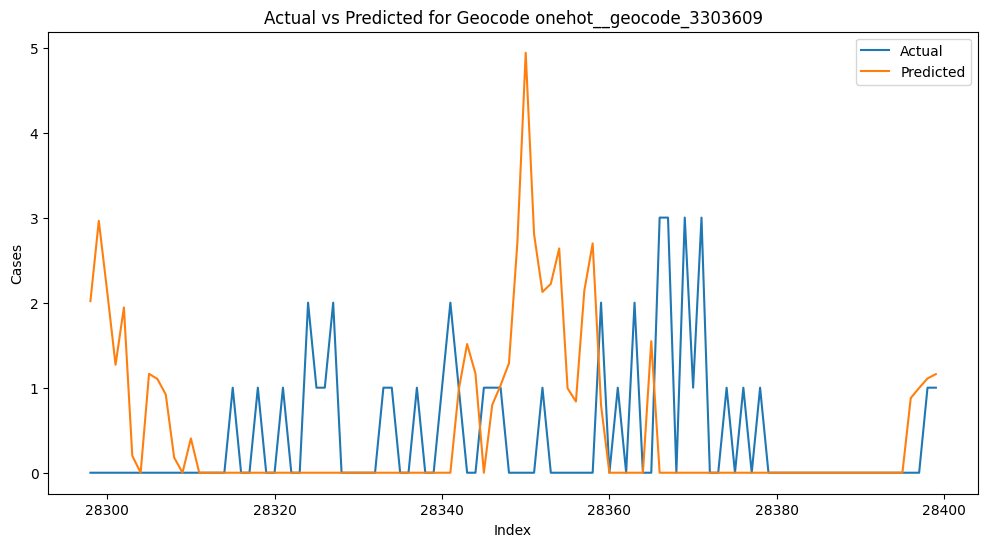

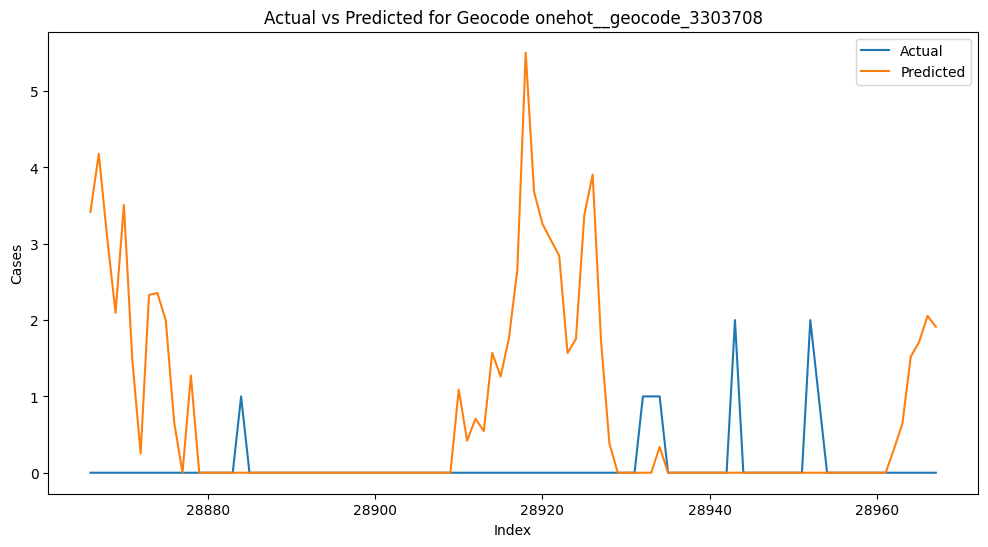

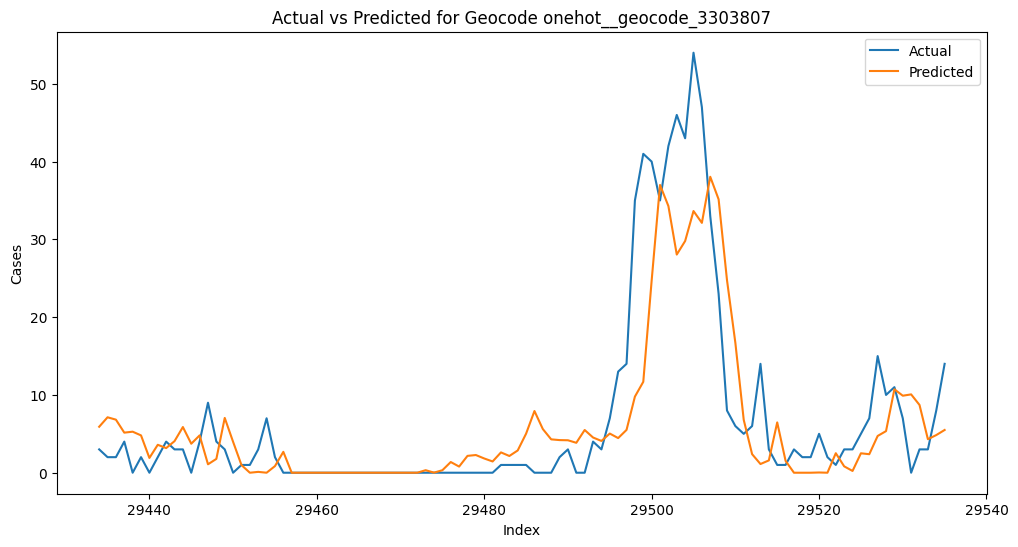

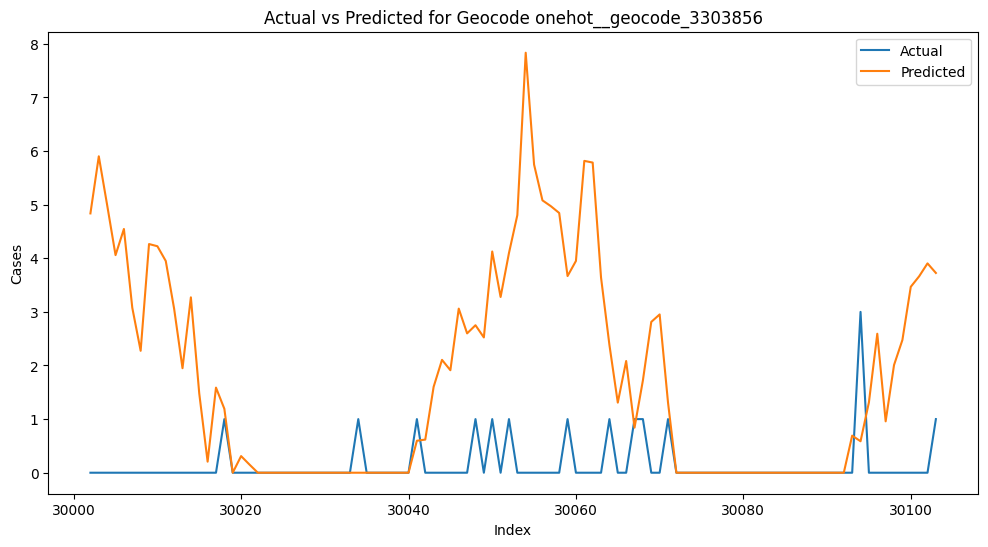

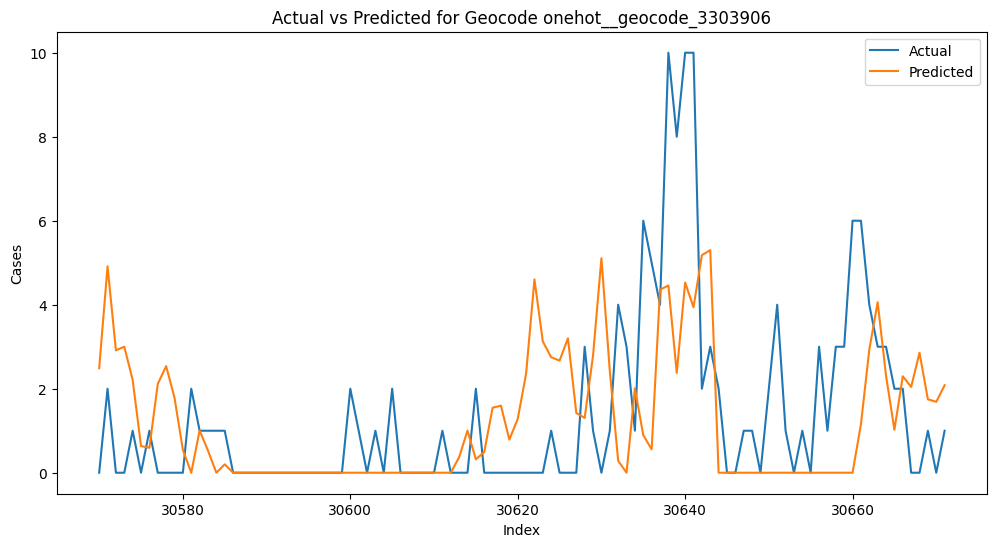

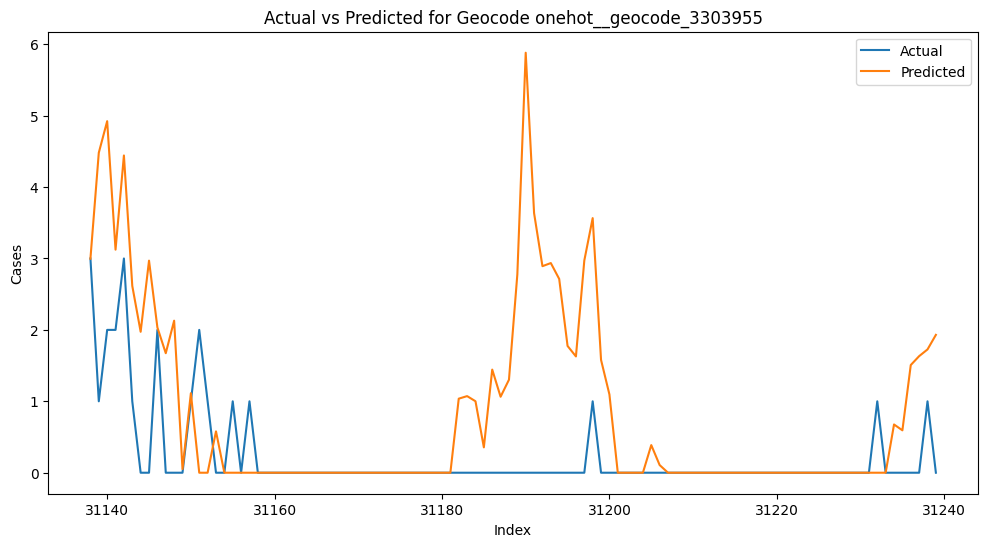

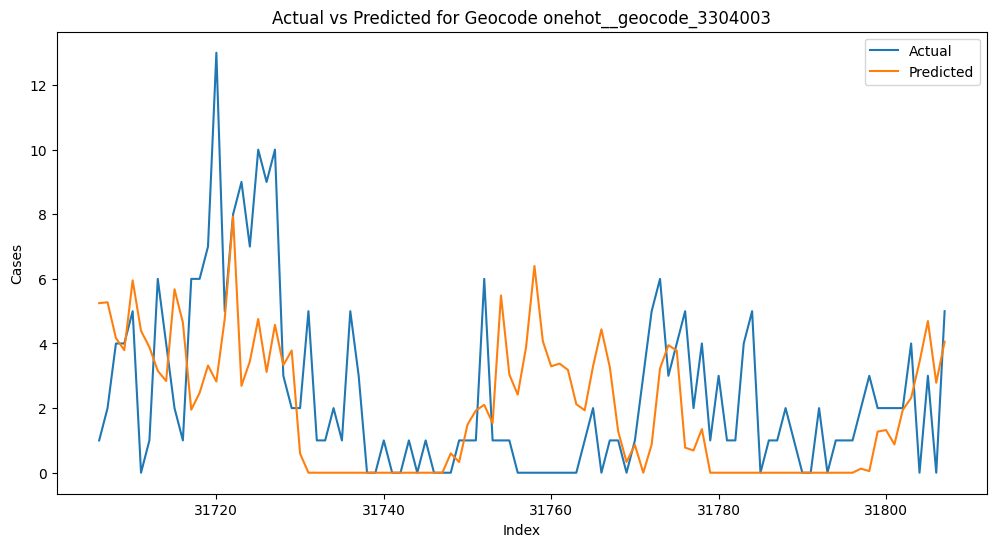

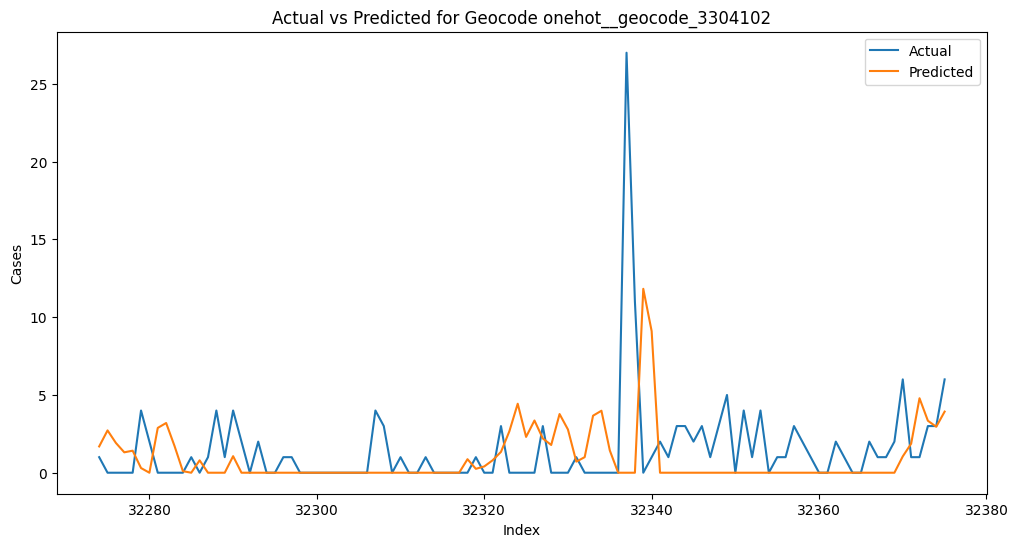

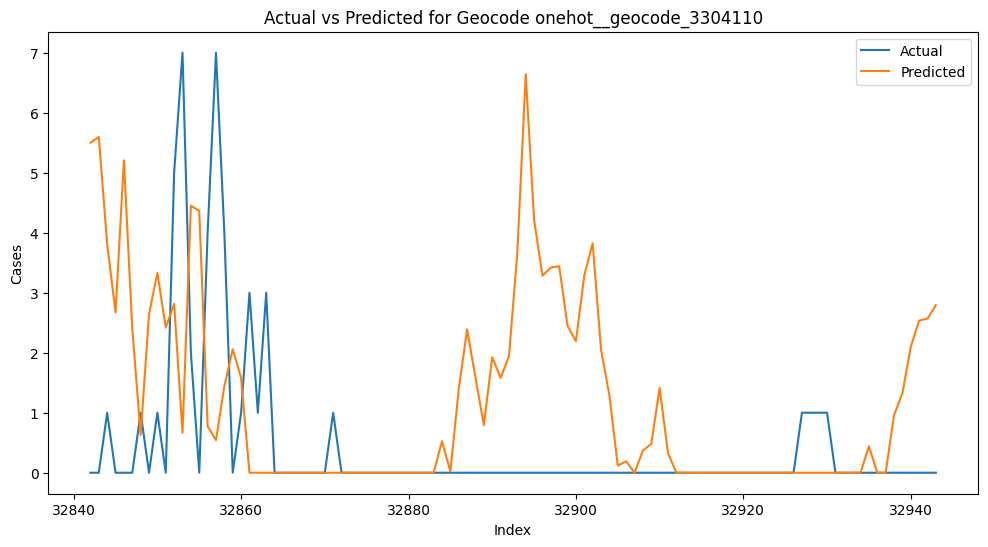

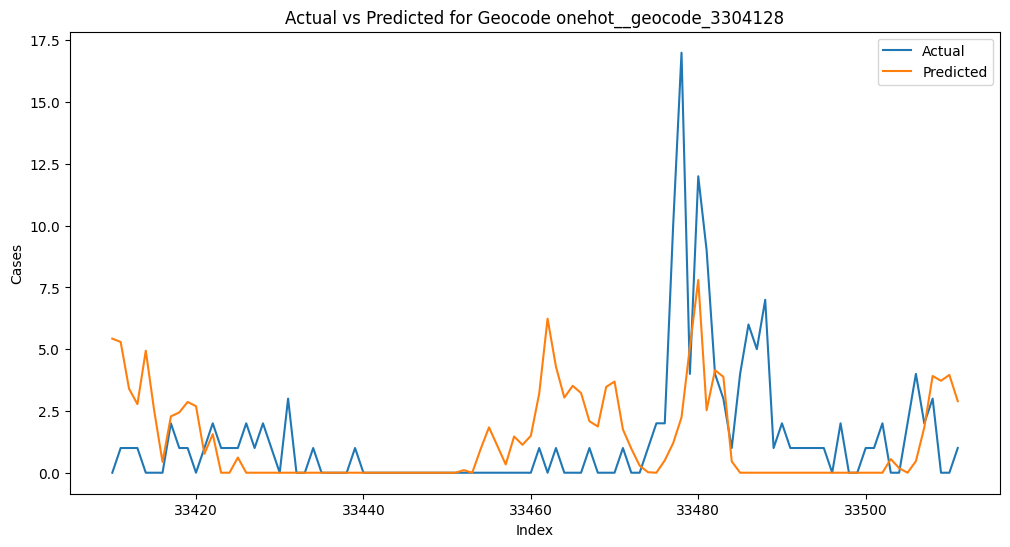

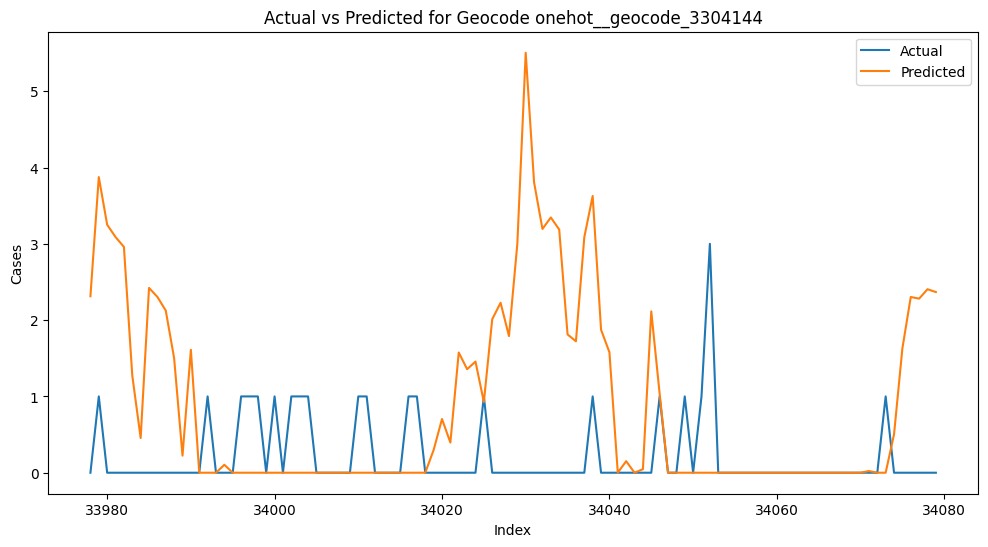

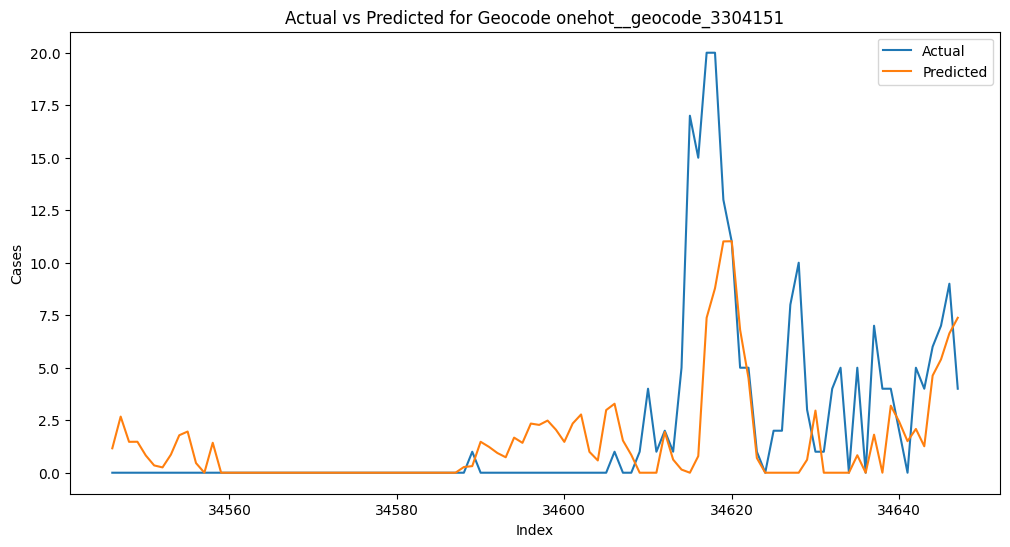

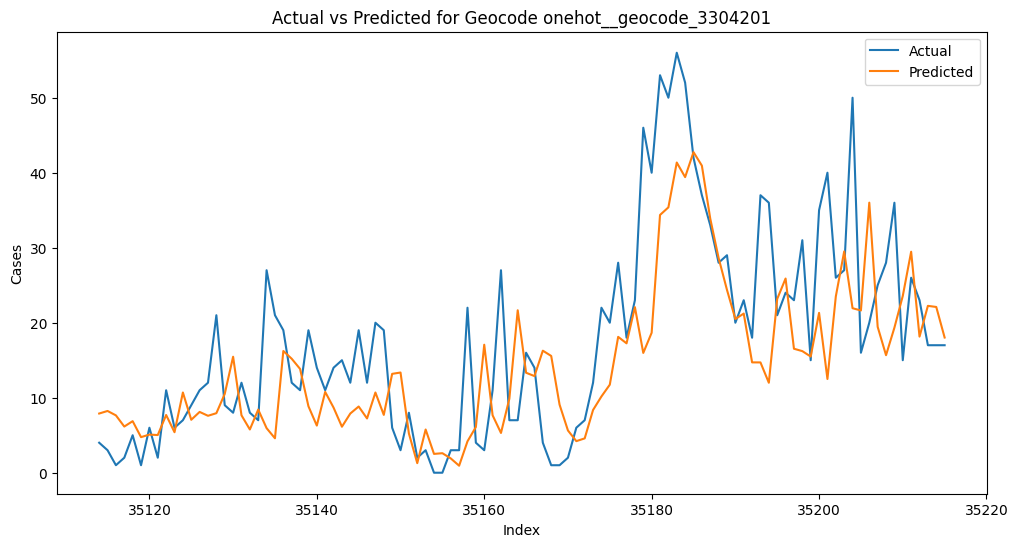

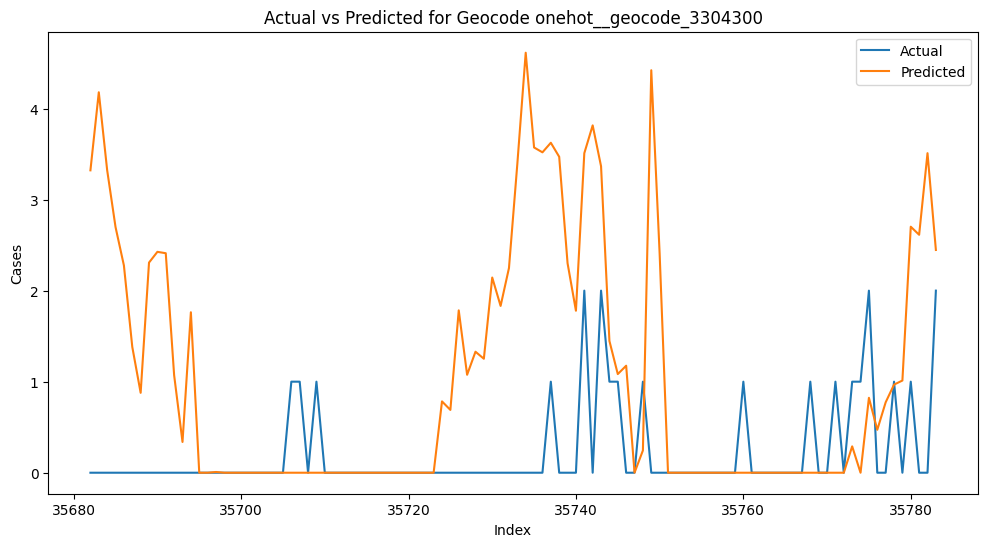

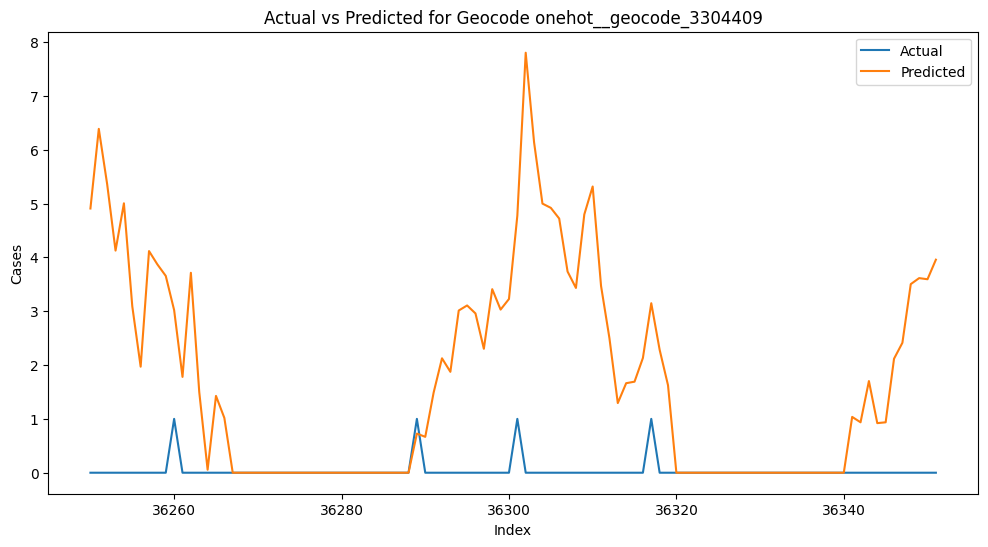

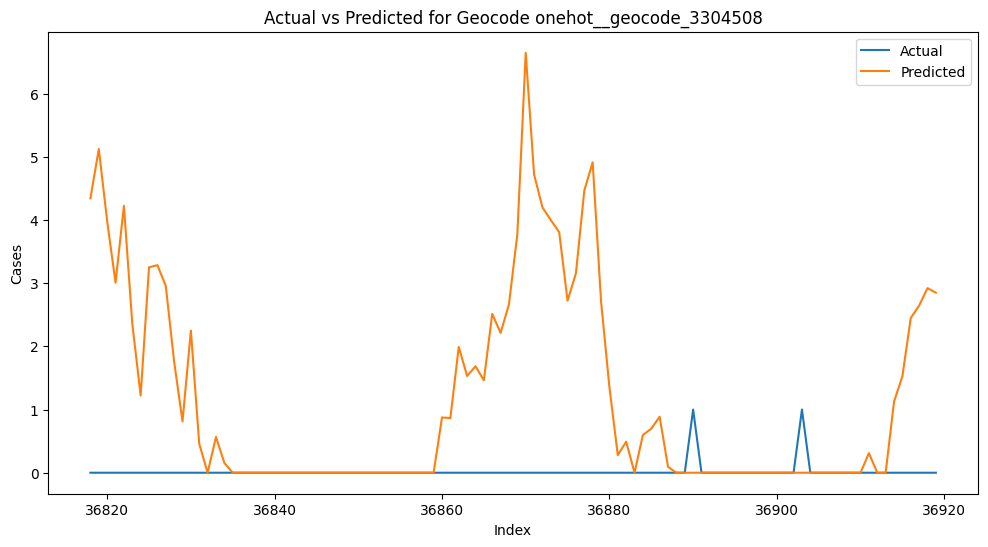

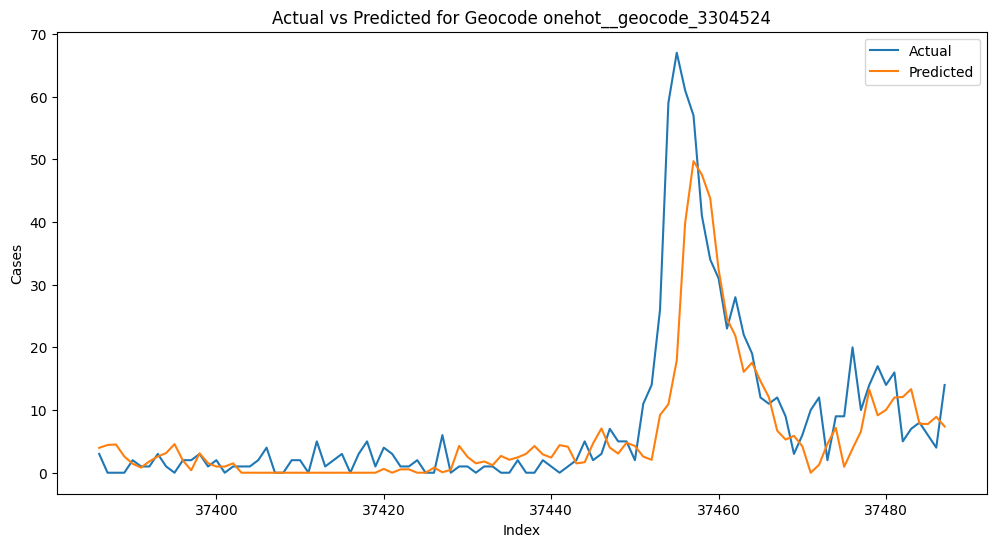

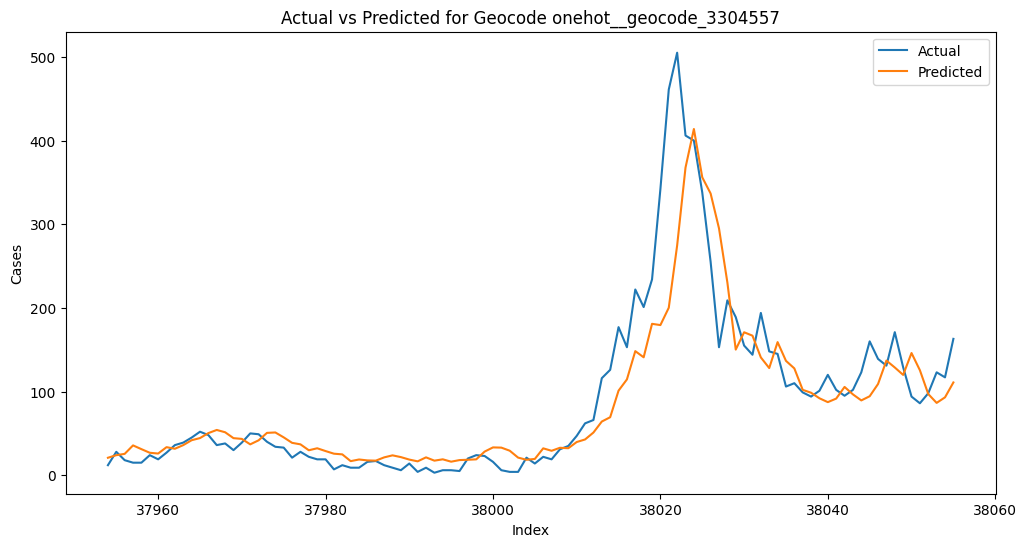

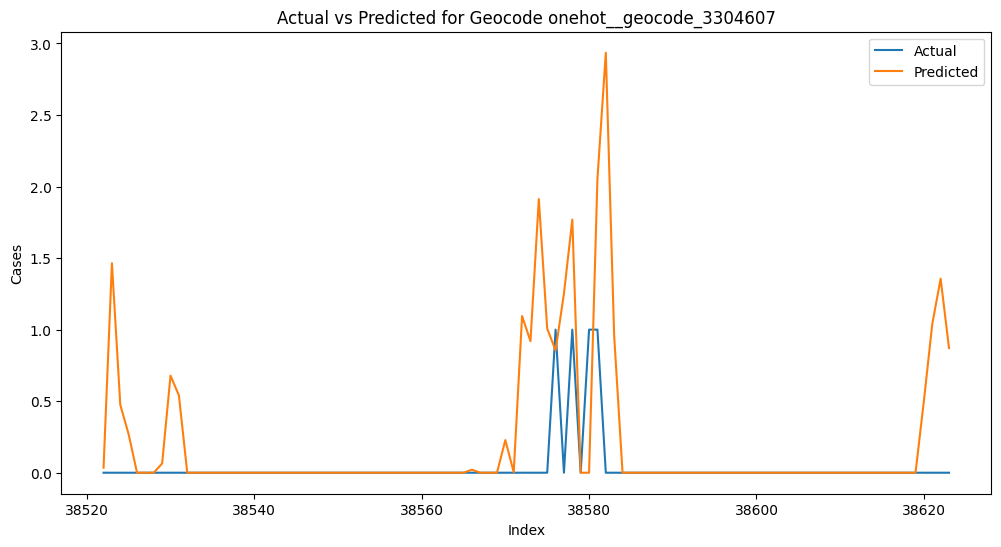

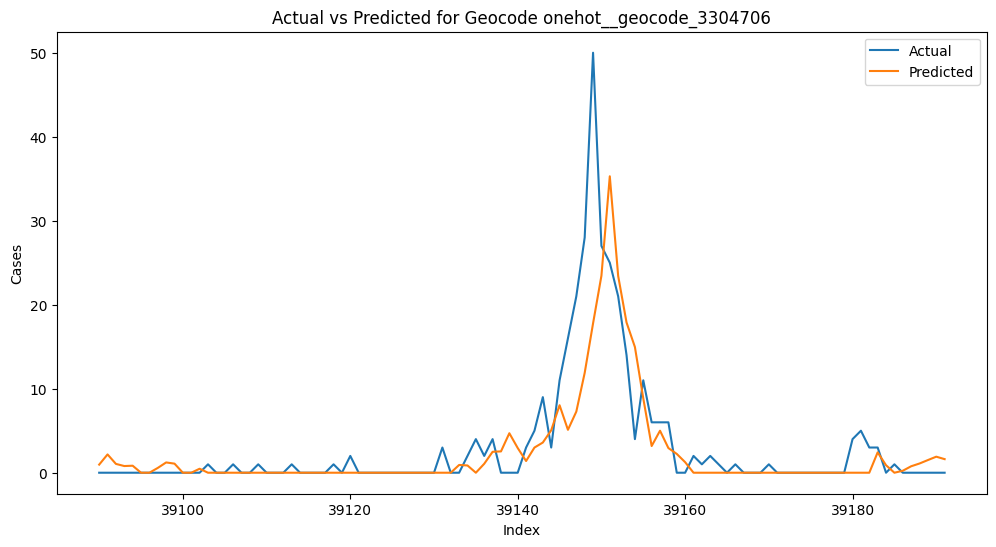

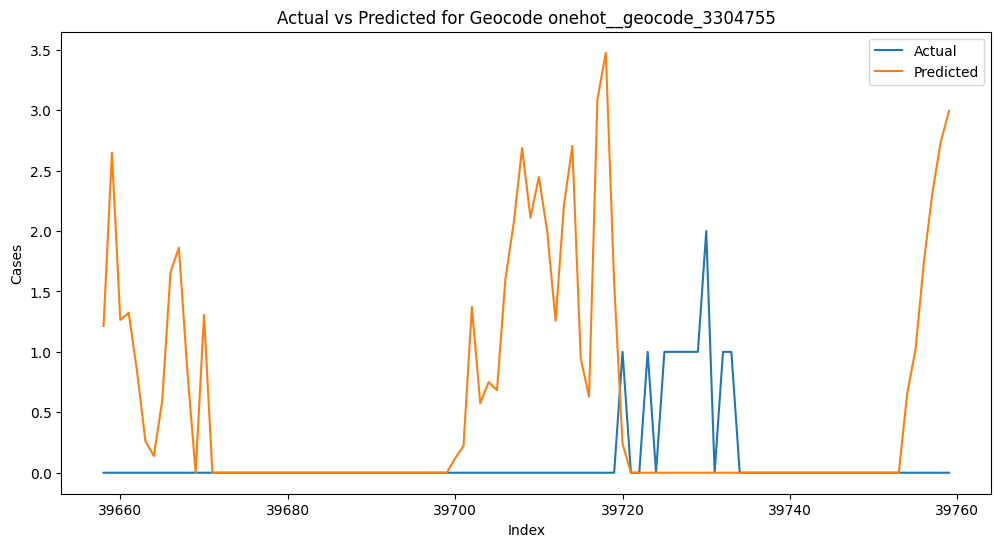

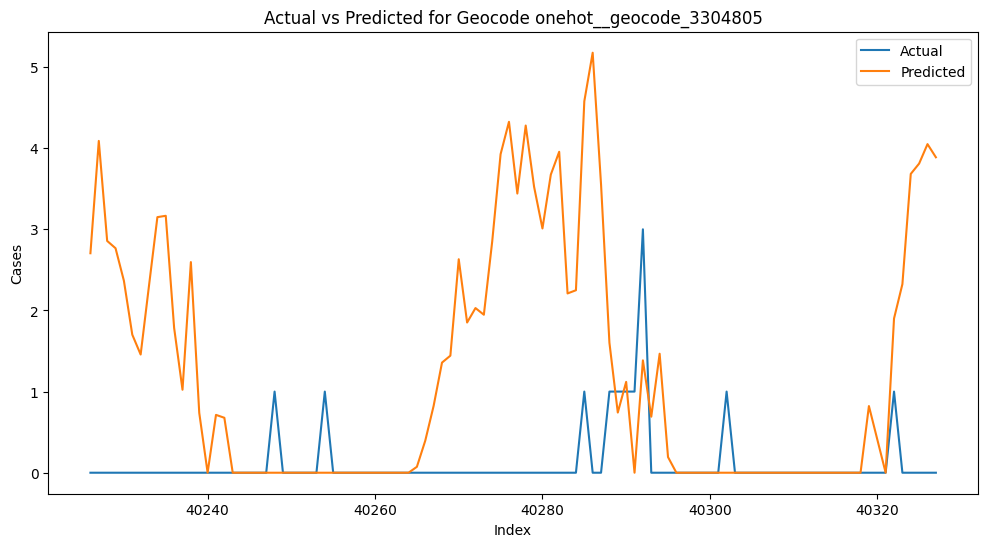

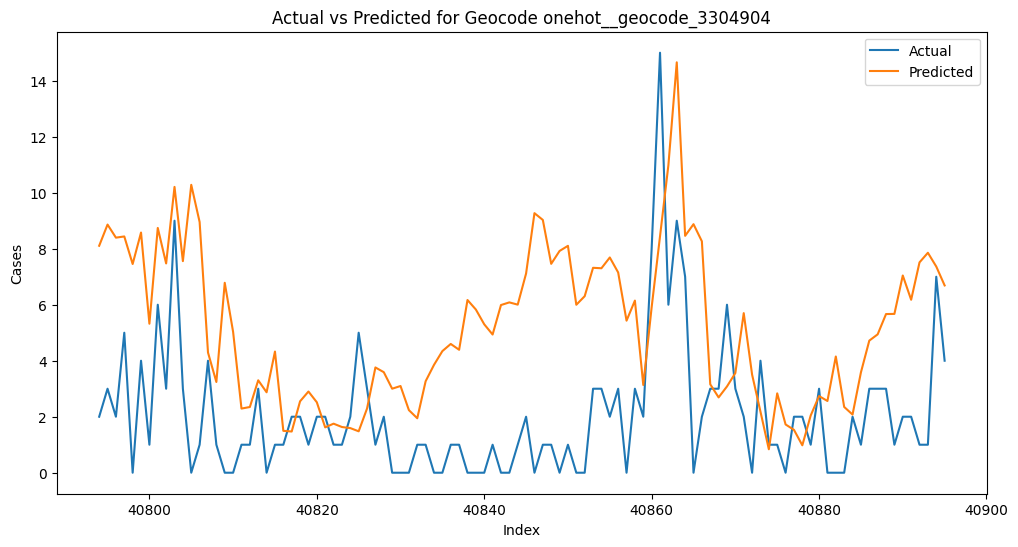

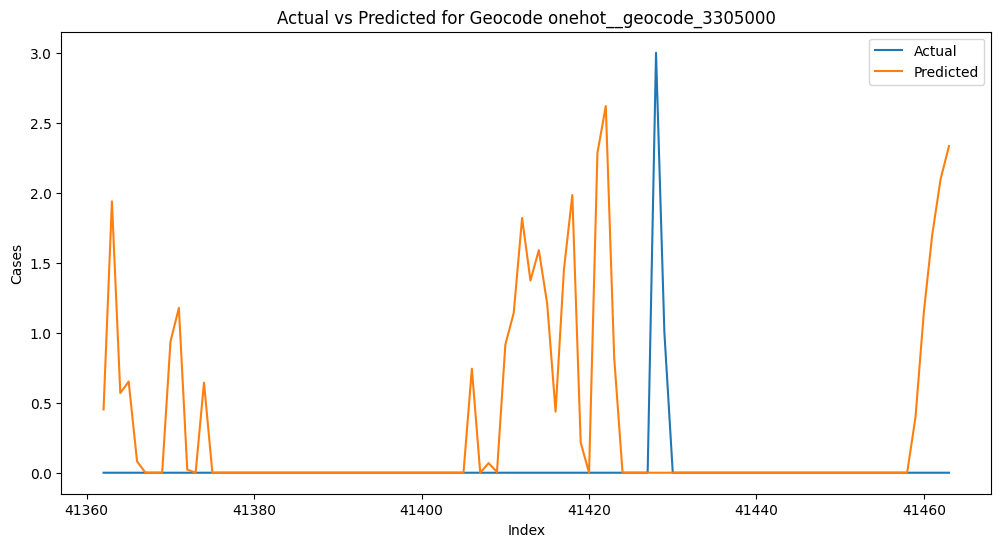

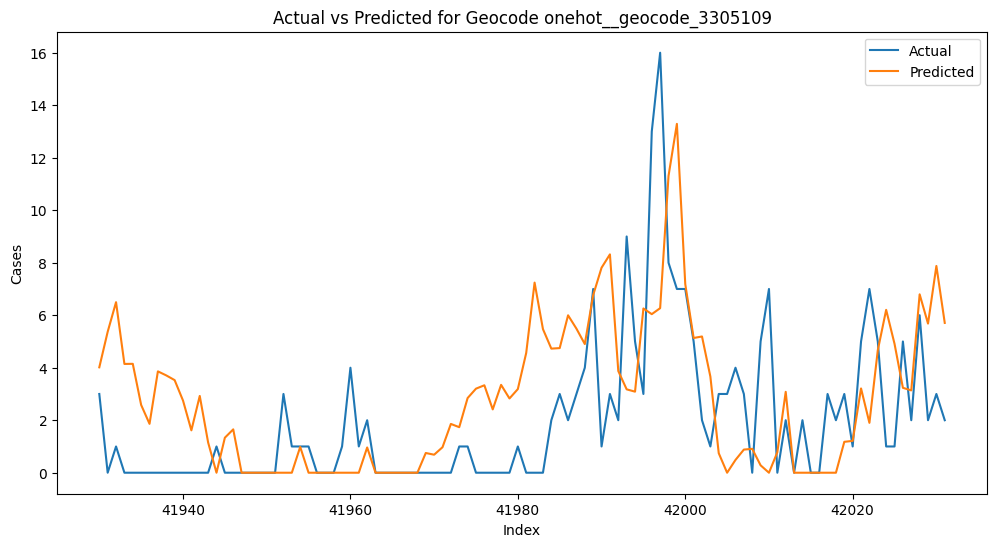

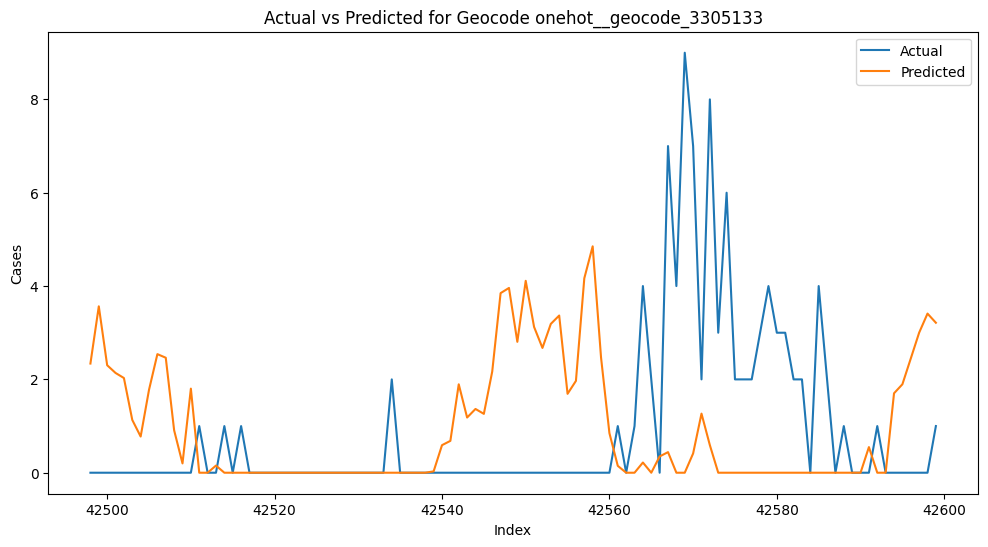

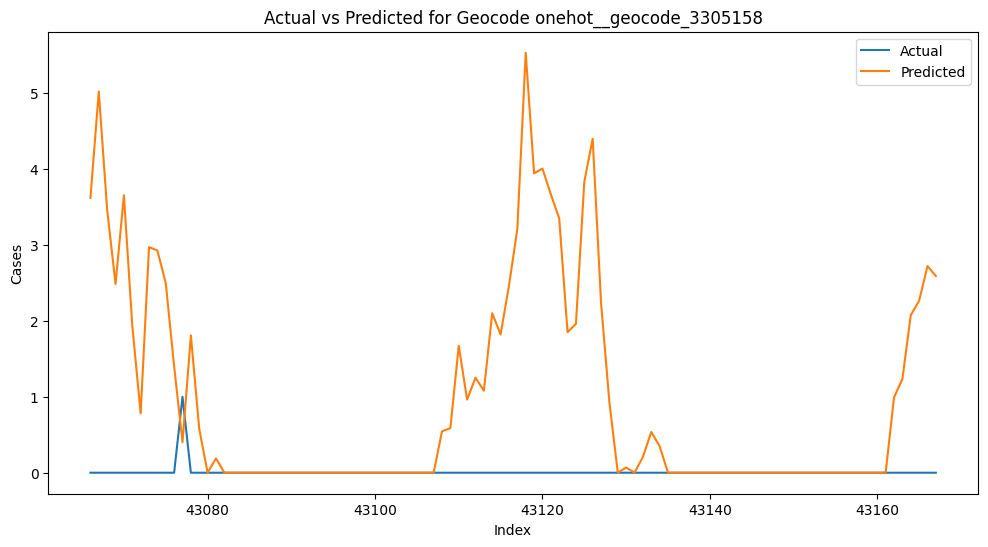

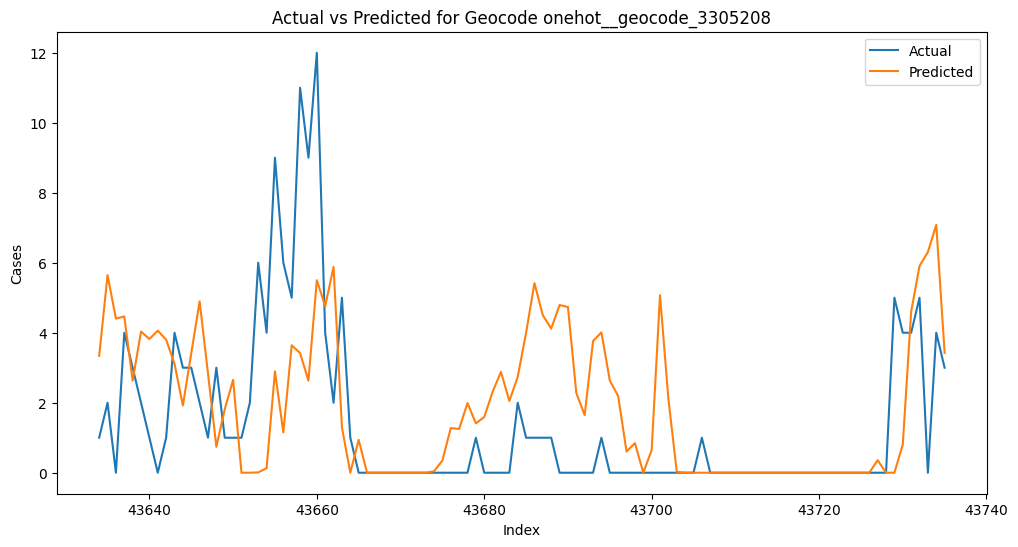

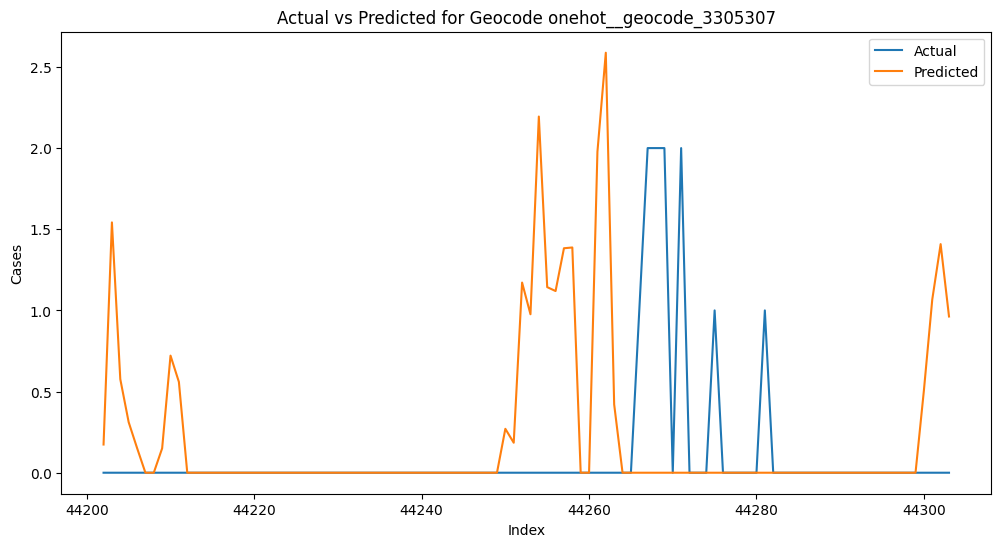

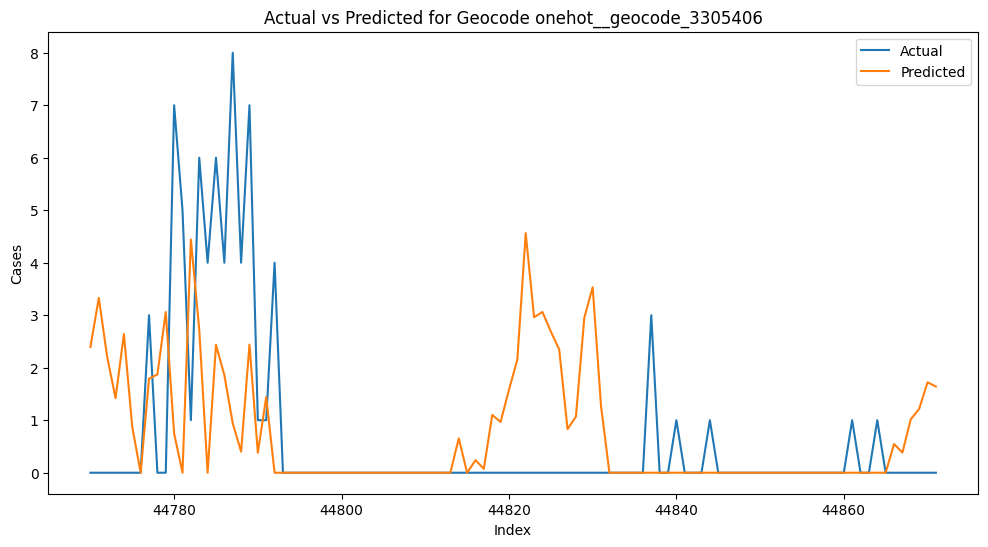

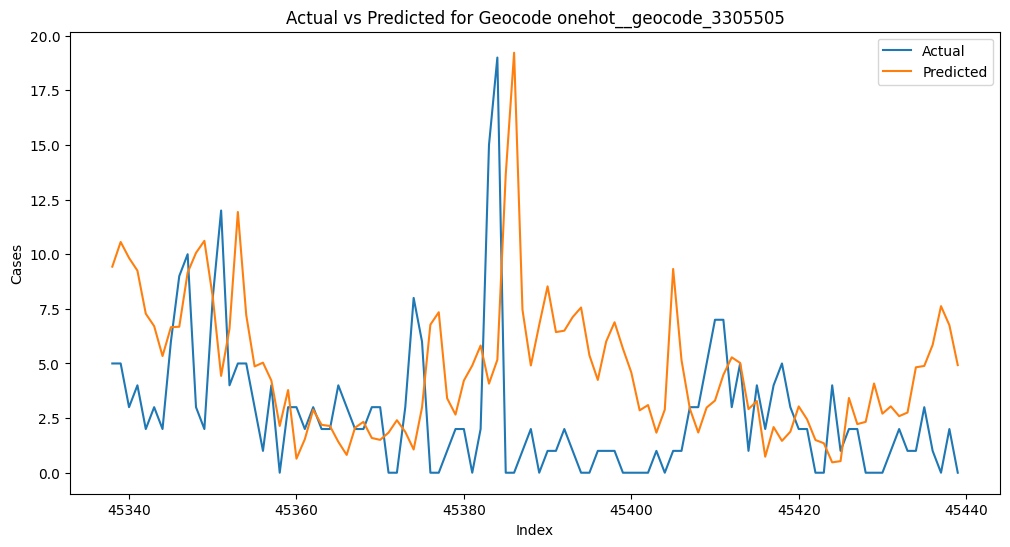

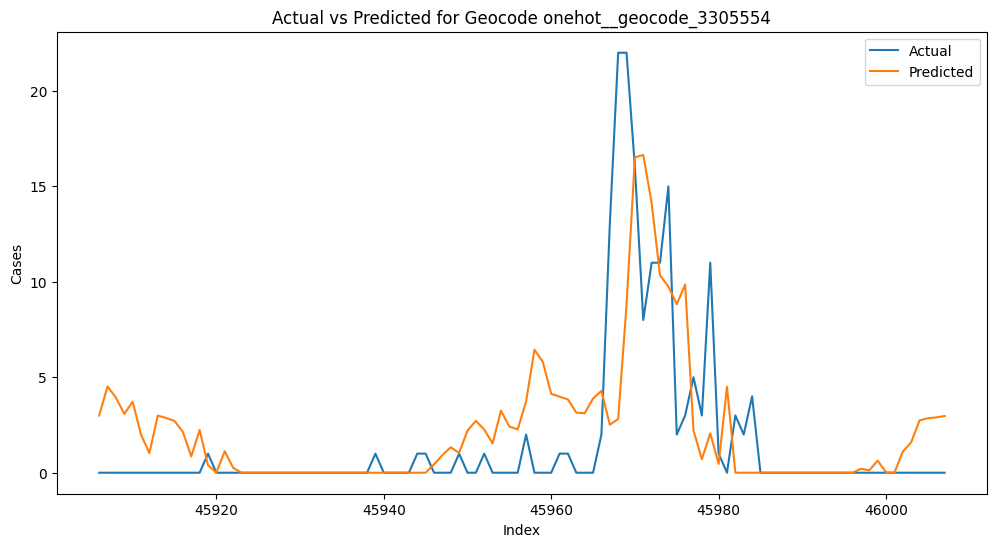

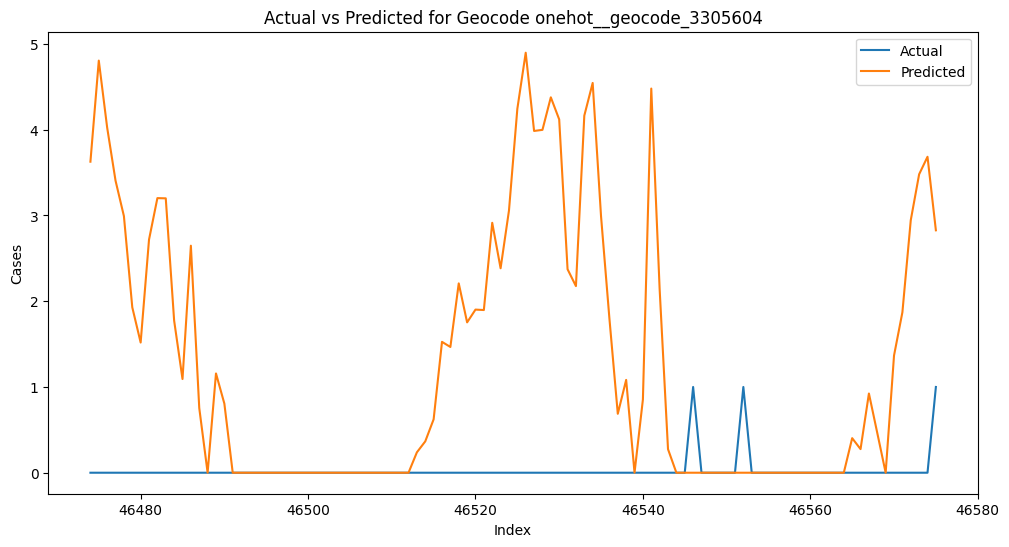

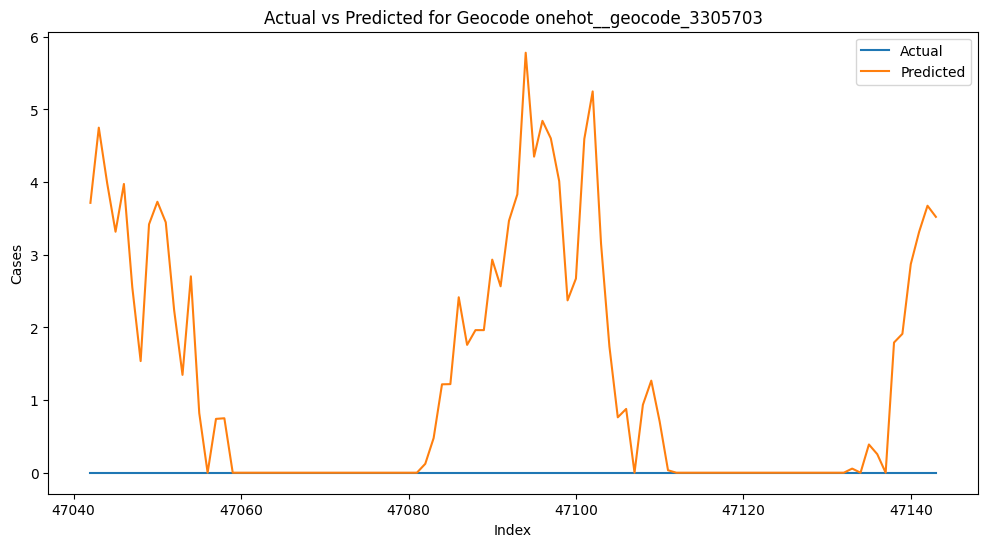

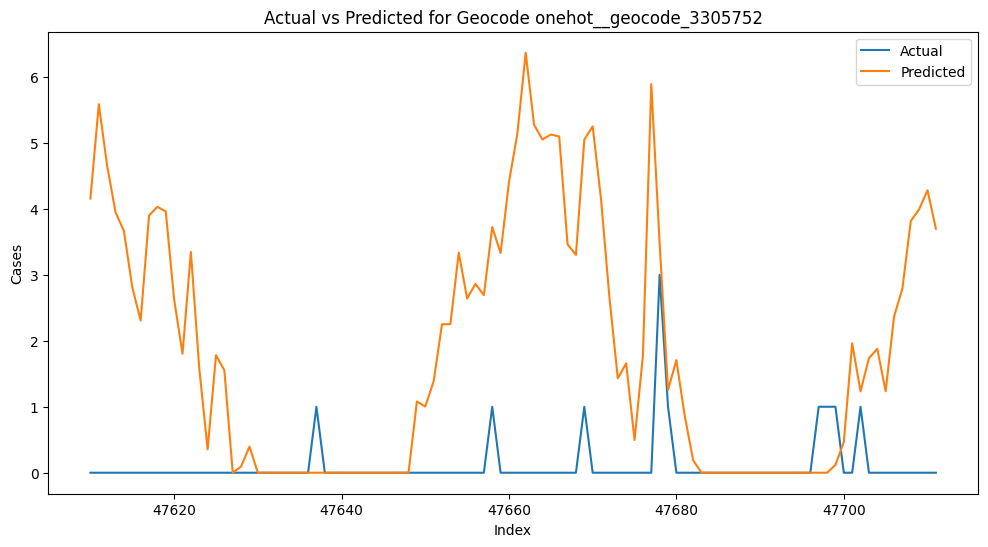

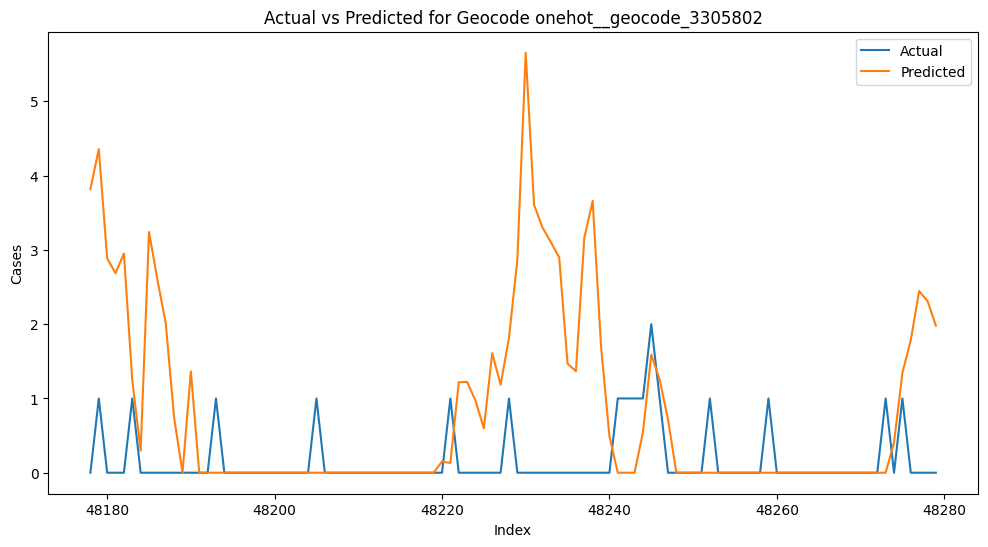

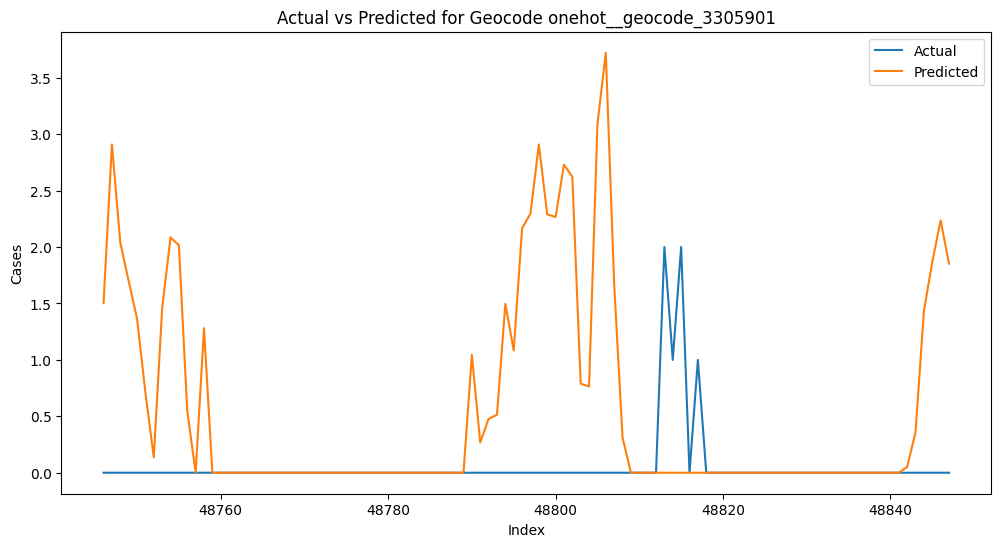

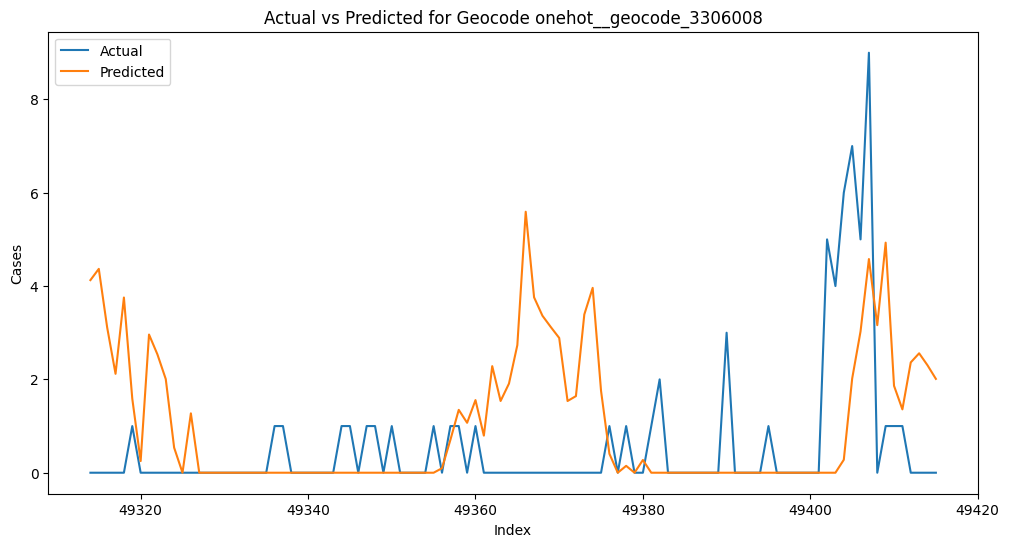

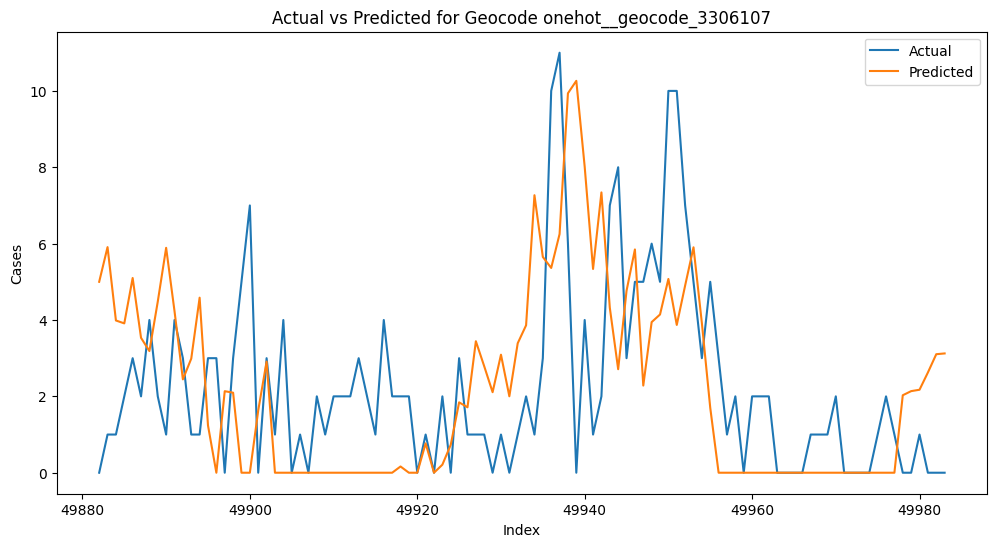

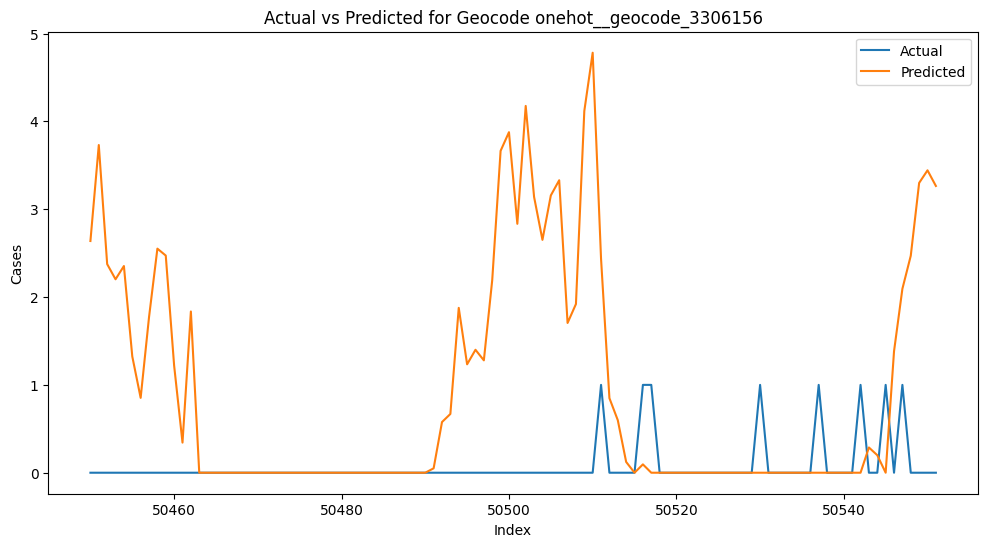

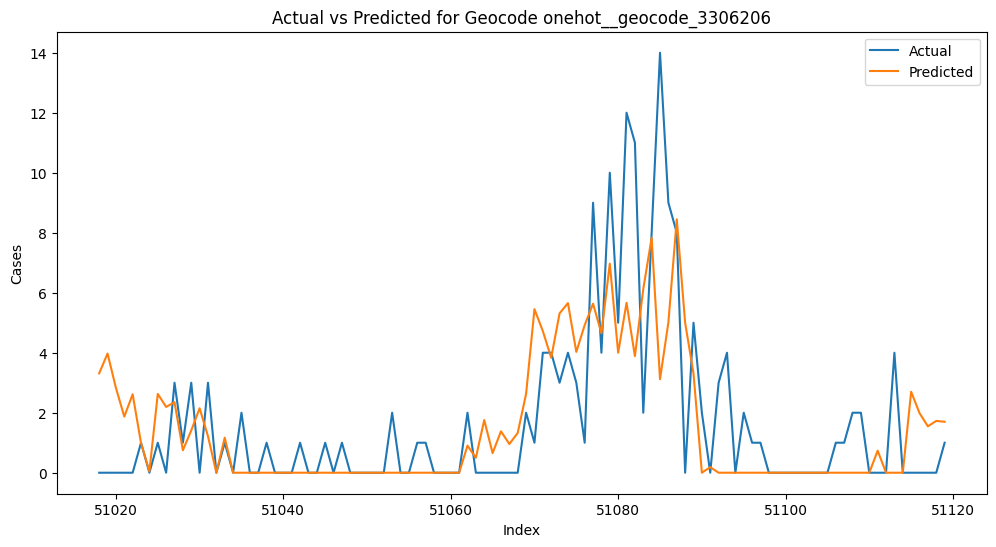

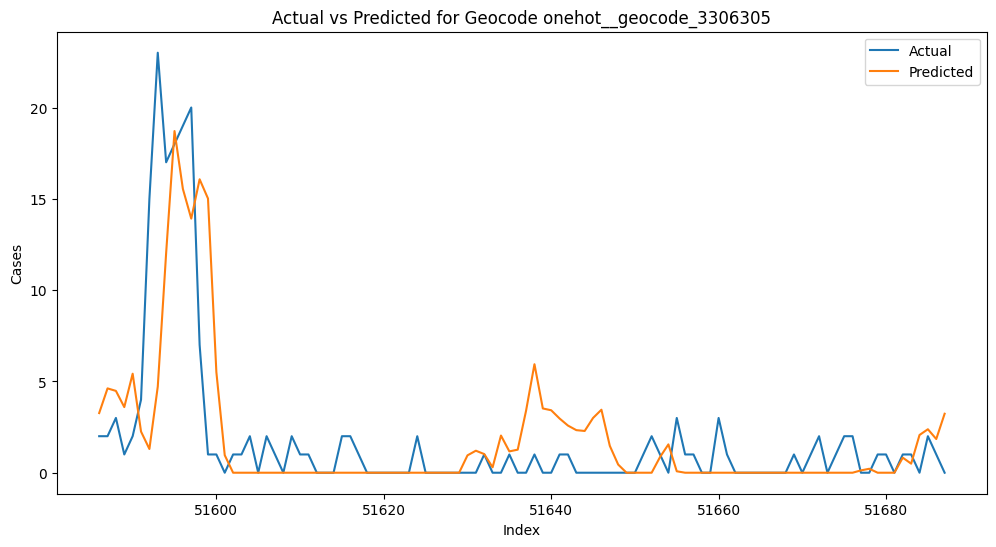

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Step 2: Define which features you'll actually use for modeling
feature_cols = [
   'cases_lag0', 'cases_lag1',
    'temp_avg', 'humidity_avg',
    'precipitation_avg_ordinary_kriging_lag3',
    'precipitation_avg_ordinary_kriging_lag4',
    'week_sin', 'month_sin', 'week_cos', 'month_cos',
    'week','vim','cases_per_100k'
]

# Add one-hot encoded columns
selected_columns = feature_cols + [col for col in data.columns if col.startswith('onehot_')]

# Step 3: Prepare feature matrix with only selected columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Step 4: Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Step 5: Scale features - only scale numeric features within selected_columns
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                   and not col.startswith('onehot_')]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

# Step 6: Scale target variable (ensuring proper shape)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

# Store best model and its performance
# Parameter combinations
C_values = [0.1]
epsilon_values = [0.0001]
kernel = "linear"  # Only using linear kernel

# Initialize best RMSE tracker
best_rmse = float("inf")
best_model = None
best_params = {}

# Iterate through parameter combinations
for C in C_values:
    for epsilon in epsilon_values:
        # Create SVR model with current parameters
        svr_params = {'C': C, 'epsilon': epsilon, 'kernel': kernel}
        svr = SVR(**svr_params)
        svr.fit(X_train, y_train_scaled)

        # Predict and calculate RMSE
        y_pred_scaled = svr.predict(X_test)

        # Inverse transform predictions
        y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

        # Calculate Root Mean Squared Error
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
        print(f"Kernel: {kernel}, C: {C}, Epsilon: {epsilon}, RMSE: {rmse:.4f}")

        # Update best model if current model performs better
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = svr
            best_params = svr_params

print("\nBest Model Parameters:", best_params)
print("Best RMSE:", best_rmse)


# Final predictions using best model
y_pred_scaled = best_model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_pred = np.clip(y_pred, 0, None)

y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()


# Final predictions using best model for the training set
y_train_pred_scaled = best_model.predict(X_train)
y_train_pred = target_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_train_pred = np.clip(y_train_pred, 0, None)

y_train_original = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()

# Calculate R-squared (R²) for the train set
r2_train = r2_score(y_train_original, y_train_pred)
print(f"R-squared (R²) for the train set: {r2_train:.4f}")

# Prepare test dataframe with results
X_test_df = pd.DataFrame(X_test, columns=selected_columns)
X_test_df["actual"] = y_test_original
X_test_df["predicted"] = y_pred



r2 = r2_score(y_test_original, y_pred)

# Print the R-squared value
print(f"R-squared (R²) for the test set: {r2:.4f}")

mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)

train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100, "%")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
# Plot Actual vs Predicted for each one-hot encoded geocode column
for geocode in X_test_df.columns:
    if geocode.startswith('onehot__geocode_'):
        # Filter the subset for rows where the current geocode column is 1
        subset = X_test_df[X_test_df[geocode] == 1]
        
        # Plot actual vs predicted cases
        plt.figure(figsize=(12, 6))
        plt.plot(subset.index, subset["actual"], label='Actual')
        plt.plot(subset.index, subset["predicted"], label='Predicted')
        plt.xlabel("Index")
        plt.ylabel("Cases")
        plt.title(f"Actual vs Predicted for Geocode {geocode}")
        plt.legend()
        plt.show()


In [32]:
# Recover date and geocode columns from test_data
test_data_for_preds = test_data.copy().reset_index(drop=True)
date_series = test_data_for_preds['date']
geocode_series = test_data_for_preds['geocode_original']

# Align lengths
assert len(date_series) == len(y_pred), "Mismatch in test length and predictions"

# Create output DataFrame
svr_output_df = pd.DataFrame({
    'geocode': geocode_series,
    'year': date_series.dt.year,
    'svr_pred': y_pred,
    'actual': y_test_original
})

# Sort by geocode and year
svr_output_df = svr_output_df.sort_values(by=['geocode', 'year'])

# Export CSVs
svr_output_df[svr_output_df['year'] == 2021][['geocode', 'svr_pred', 'actual']].to_csv('svr_preds_2021.csv', index=False)
svr_output_df[svr_output_df['year'] == 2022][['geocode', 'svr_pred', 'actual']].to_csv('svr_test_preds_2022.csv', index=False)

print("Prediction files saved: svr_preds.csv and svr_test_preds.csv")

Prediction files saved: svr_preds.csv and svr_test_preds.csv
